## 1. Setup and Data Loading <a id="1-setup"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [3]:
# Define paths
human_data_dir = Path("../data/humnan-annotator-results")
llm_data_dir = Path("../data/llm-annotator-results")

# Load human annotators
human_annotators = ['A', 'B', 'C']
human_data = {}
for annotator in human_annotators:
    file_path = human_data_dir / f'annotations_{annotator}.csv'
    df = pd.read_csv(file_path)
    human_data[annotator] = df
    print(f"✓ Loaded human {annotator}: {len(df)} annotations")

# Load LLM annotators from all rounds
llm_data = {}

# Scan all round folders (r1, r2, etc.)
for round_folder in sorted(llm_data_dir.iterdir()):
    if not round_folder.is_dir():
        continue
    
    # To manually exclude certain rounds, uncomment and modify the following line:
    # if round_folder.name  in ['r2', 'r3']:
    #     continue
    
    round_name = round_folder.name
    print(f"\n📁 Processing round: {round_name}")
    
    # Load all CSV files in this round
    for csv_file in sorted(round_folder.glob("annotations_*.csv")):
        # Extract LLM name from filename: annotations_ollama_model_name.csv
        # Keep underscores, don't replace with spaces
        base_llm_name = csv_file.stem.replace('annotations_ollama_', '')
        
        # Add round suffix with underscore (no spaces, no parentheses)
        llm_name_with_round = f"{base_llm_name}_{round_name}"
        
        # Load dataframe
        df = pd.read_csv(csv_file)
        
        # CRITICAL: Store with round-suffixed name as key to avoid overwriting
        llm_data[llm_name_with_round] = df
        print(f"  ✓ Loaded {llm_name_with_round}: {len(df)} annotations")

# Create list of all LLM annotator names
llm_annotators = list(llm_data.keys())

print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"Human annotators: {len(human_annotators)}")
print(f"LLM annotators: {len(llm_annotators)}")
print(f"Total annotators: {len(human_annotators) + len(llm_annotators)}")
print(f"\nLLM models loaded:")
for llm in sorted(llm_annotators):
    print(f"  - {llm}")
print(f"{'='*80}")

✓ Loaded human A: 911 annotations
✓ Loaded human B: 1000 annotations
✓ Loaded human C: 911 annotations

📁 Processing round: r1
  ✓ Loaded codellama_13b_r1: 50 annotations
  ✓ Loaded deepseek-r1_14b_r1: 50 annotations
  ✓ Loaded gemma3_12b_r1: 50 annotations
  ✓ Loaded gpt-oss_20b_r1: 50 annotations
  ✓ Loaded llama3.1_8b_r1: 50 annotations
  ✓ Loaded mistral_7b_r1: 50 annotations
  ✓ Loaded qwen3-coder_30b_r1: 50 annotations

📁 Processing round: r2
  ✓ Loaded Hermes-4.3-36b_r2: 50 annotations
  ✓ Loaded codellama_13b_r2: 50 annotations
  ✓ Loaded deepseek-r1_14b_r2: 50 annotations
  ✓ Loaded deepseek-r1_70b_r2: 50 annotations
  ✓ Loaded gemma3_12b_r2: 50 annotations
  ✓ Loaded gpt-oss_120b_r2: 50 annotations
  ✓ Loaded gpt-oss_20b_r2: 50 annotations
  ✓ Loaded llama3.1_70b_r2: 50 annotations
  ✓ Loaded llama3.1_8b_r2: 50 annotations
  ✓ Loaded mistral_7b_r2: 50 annotations
  ✓ Loaded qwen3-coder_30b_r2: 50 annotations

SUMMARY
Human annotators: 3
LLM annotators: 18
Total annotators: 21

In [4]:
# Define categories and create unified dataset
categories = ['bfc', 'bpc', 'prc', 'nfc']

def prepare_unified_data(human_data, llm_data, categories):
    """
    Create a unified dataset with all annotations.
    Returns a dictionary: {category: DataFrame with columns [hash, A, B, C, llm1, llm2, ...]}
    """
    unified = {}
    
    for category in categories:
        # Start with human annotations
        category_df = human_data['A'][['hash', category]].rename(columns={category: 'A'}).copy()
        
        # Add human annotator columns
        for annotator in ['B', 'C']:
            df = human_data[annotator]
            category_df = category_df.merge(
                df[['hash', category]].rename(columns={category: annotator}),
                on='hash',
                how='inner'
            )
        
        # Add LLM columns
        for llm_name, df in llm_data.items():
            category_df = category_df.merge(
                df[['hash', category]].rename(columns={category: llm_name}),
                on='hash',
                how='inner'
            )
        
        # Drop rows with missing values (should not be needed with inner joins, but as safety)
        category_df = category_df.dropna()
        unified[category] = category_df
        
        print(f"{category.upper()}: {len(category_df)} commits with complete annotations")
    
    return unified

unified_data = prepare_unified_data(human_data, llm_data, categories)

BFC: 50 commits with complete annotations
BPC: 50 commits with complete annotations
PRC: 50 commits with complete annotations
NFC: 50 commits with complete annotations


### Epsilon (ε) Selection: Cost-Benefit Hyperparameter

Before proceeding with the analysis, we need to set the **cost-benefit hyperparameter ε**, which adjusts the threshold the LLM must exceed in the alt-test.

#### Why Use ε > 0?

LLMs offer a **cheaper, faster, and less labor-intensive** alternative to human annotators. The hyperparameter ε accounts for this advantage by lowering the threshold the LLM must beat (ρ^h_j - ε instead of ρ^h_j).

#### Rule of Thumb for Setting ε:

1. **ε = 0.2**: For trusted experts or highly reliable annotators
2. **ε = 0.15**: For skilled annotators (e.g., undergraduate students, trained workers)
3. **ε = 0.1**: For crowd workers or annotators with low reliability

#### Effective Range:
- **ε > 0.3**: Almost all LLMs pass (too lenient)
- **0.05 ≤ ε ≤ 0.3**: Effective range with meaningful discrimination
- **ε < 0.05**: Almost all LLMs fail (too strict)

#### Our Choice:

**ε = 0.15** (skilled annotators)

**Justification**:
- Human annotators in this study are graduate-level researchers
- They received training on commit classification methodology
- The annotation task requires domain knowledge (software engineering, Linux kernel)
- This is not a simple task for untrained crowd workers
- Moderate IAA suggests skilled but not expert-level annotators

We will also test **ε = 0.1** and **ε = 0.2** for sensitivity analysis.

In [5]:
# Configuration: Epsilon values to test
EPSILON_PRIMARY = 0.15  # Primary epsilon for skilled annotators
EPSILON_SENSITIVITY = [0.0, 0.05, 0.1, 0.15, 0.2]  # Sensitivity analysis
ALPHA = 0.05  # Significance level

print(f"Primary epsilon (ε): {EPSILON_PRIMARY}")
print(f"Sensitivity analysis: ε ∈ {EPSILON_SENSITIVITY}")
print(f"Significance level (α): {ALPHA}")
print(f"\nJustification: Graduate-level researchers with training (skilled annotators)")
print(f"              → ε = {EPSILON_PRIMARY} is appropriate")

Primary epsilon (ε): 0.15
Sensitivity analysis: ε ∈ [0.0, 0.05, 0.1, 0.15, 0.2]
Significance level (α): 0.05

Justification: Graduate-level researchers with training (skilled annotators)
              → ε = 0.15 is appropriate


In [6]:
# Display sample data
print("\nSample data for BFC category:")
display(unified_data['bfc'].head())

print("\nDataset shapes:")
for cat in categories:
    print(f"{cat.upper()}: {unified_data[cat].shape}")


Sample data for BFC category:


,hash,A,B,C,codellama_13b_r1,deepseek-r1_14b_r1,gemma3_12b_r1,gpt-oss_20b_r1,llama3.1_8b_r1,mistral_7b_r1,...,codellama_13b_r2,deepseek-r1_14b_r2,deepseek-r1_70b_r2,gemma3_12b_r2,gpt-oss_120b_r2,gpt-oss_20b_r2,llama3.1_70b_r2,llama3.1_8b_r2,mistral_7b_r2,qwen3-coder_30b_r2
0,3044a4f271,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,e1553351d7,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2fadc6ea4a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,805a3ebed5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9b51d9d866,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Dataset shapes:
BFC: (50, 22)
BPC: (50, 22)
PRC: (50, 22)
NFC: (50, 22)


## 2. Scoring Functions <a id="2-scoring"></a>

We'll use **negative RMSE** as it's more appropriate for ordinal Likert scales.

### Negative RMSE
For continuous/ordinal annotations:
$$-RMSE(f, x_i, j) = - \sqrt{\frac{1}{|H_i| - 1} \sum_{k \in H_i[-j]} (f(x_i) - h_k(x_i))^2}$$

In [7]:
def compute_rmse_score(f_annotation, other_annotations):
    """
    Compute negative RMSE alignment score.
    
    Args:
        f_annotation: Single annotation value (from LLM or excluded human)
        other_annotations: Array of annotations from other humans
    
    Returns:
        Negative RMSE score (higher is better)
    """
    return -np.sqrt(np.mean((f_annotation - other_annotations) ** 2))

# Test the scoring function
test_f = 3
test_others = np.array([4, 3])
print(f"Test annotation: f={test_f}, others={test_others}")
print(f"RMSE score: {compute_rmse_score(test_f, test_others):.3f}")

Test annotation: f=3, others=[4 3]
RMSE score: -0.707


## 3. Advantage Probability Computation <a id="3-advantage"></a>

We compute advantage probabilities using the leave-one-out approach:

### For each instance $x_i$ and excluded annotator $h_j$:

1. Compute $S(f, x_i, j)$: LLM's alignment with remaining humans
2. Compute $S(h_j, x_i, j)$: Excluded human's alignment with remaining humans
3. Define indicator:
$$W^{f}_{i,j} = \begin{cases} 1, & \text{if } S(f, x_i, j) \geq S(h_j, x_i, j) \\ 0, & \text{otherwise} \end{cases}$$

4. Estimate advantage probability:
$$\rho^f_j = \frac{1}{|I_j|} \sum_{i \in I_j} W^{f}_{i,j}$$

In [8]:
def compute_advantage_probabilities(df, llm_name, human_annotators, score_func=compute_rmse_score):
    """
    Compute advantage probabilities for a single LLM against all human annotators.
    
    Args:
        df: DataFrame with columns [hash, A, B, C, llm_name]
        llm_name: Name of the LLM column
        human_annotators: List of human annotator names
        score_func: Scoring function to use (compute_rmse_score or compute_acc_score)
    
    Returns:
        Dictionary with results for each excluded human:
        {human_j: {'rho_f': prob_llm_wins, 'rho_h': prob_human_wins, 'W_f': indicators_llm, 'W_h': indicators_human}}
    """
    results = {}
    
    for excluded_human in human_annotators:
        # Get remaining humans
        remaining_humans = [h for h in human_annotators if h != excluded_human]
        
        W_f_list = []  # Indicators for LLM winning
        W_h_list = []  # Indicators for human winning
        
        # For each instance (commit)
        for idx, row in df.iterrows():
            # Get annotations
            llm_annotation = row[llm_name]
            excluded_annotation = row[excluded_human]
            remaining_annotations = row[remaining_humans].values
            
            # Compute alignment scores
            S_llm = score_func(llm_annotation, remaining_annotations)
            S_human = score_func(excluded_annotation, remaining_annotations)
            
            # Compute indicators
            W_f = 1 if S_llm >= S_human else 0
            W_h = 1 if S_human >= S_llm else 0
            
            W_f_list.append(W_f)
            W_h_list.append(W_h)
        
        # Compute advantage probabilities
        rho_f = np.mean(W_f_list)
        rho_h = np.mean(W_h_list)
        
        results[excluded_human] = {
            'rho_f': rho_f,
            'rho_h': rho_h,
            'W_f': W_f_list,
            'W_h': W_h_list,
            'n_instances': len(W_f_list)
        }
    
    return results

In [9]:
# Test advantage probability computation for BFC category with one LLM
test_llm = "gpt-oss_120b_r2"
test_results = compute_advantage_probabilities(
    unified_data['bfc'], 
    test_llm, 
    human_annotators
)

print(f"\nTest results for {test_llm} on BFC category:")
for human, res in test_results.items():
    print(f"  vs {human}: ρ^f={res['rho_f']:.3f}, ρ^h={res['rho_h']:.3f}, n={res['n_instances']}")


Test results for gpt-oss_120b_r2 on BFC category:
  vs A: ρ^f=0.920, ρ^h=0.980, n=50
  vs B: ρ^f=0.920, ρ^h=0.940, n=50
  vs C: ρ^f=0.920, ρ^h=0.980, n=50


In [10]:
llm_data.keys()

dict_keys(['codellama_13b_r1', 'deepseek-r1_14b_r1', 'gemma3_12b_r1', 'gpt-oss_20b_r1', 'llama3.1_8b_r1', 'mistral_7b_r1', 'qwen3-coder_30b_r1', 'Hermes-4.3-36b_r2', 'codellama_13b_r2', 'deepseek-r1_14b_r2', 'deepseek-r1_70b_r2', 'gemma3_12b_r2', 'gpt-oss_120b_r2', 'gpt-oss_20b_r2', 'llama3.1_70b_r2', 'llama3.1_8b_r2', 'mistral_7b_r2', 'qwen3-coder_30b_r2'])

## 4. Statistical Testing <a id="4-testing"></a>

### Hypothesis Testing with Bootstrap Test

We test the hypothesis:
$$H_{0j}: \rho^f_j \leq \rho^h_j - \epsilon \quad \text{vs.} \quad H_{1j}: \rho^f_j > \rho^h_j - \epsilon$$

Using difference indicators: $d_{i,j} = W^{h}_{i,j} - W^{f}_{i,j}$

Since $\rho^h - \rho^f = E[d]$, the hypothesis can be equivalently written as:
$$H_{0j}: E[d_j] \geq \epsilon \quad \text{vs.} \quad H_{1j}: E[d_j] < \epsilon$$

This means we test whether the expected difference in advantage probabilities is at least $\epsilon$ (human is better), or less than $\epsilon$ (LLM is practically equivalent or better).

### Bootstrap Test Implementation

The **Bootstrap Test** uses resampling to test whether $E[d_j] < \epsilon$ without assuming any particular distribution:

1. **Resample with replacement**: Generate 10,000 bootstrap samples from the observed differences $d_{i,j}$
2. **Compute bootstrap means**: Calculate $\bar{d}_{boot}$ for each bootstrap sample
3. **Calculate p-value**: Proportion of bootstrap samples where $\bar{d}_{boot} \geq \epsilon$

If the p-value is small, we reject $H_0$ and conclude that $E[d] < \epsilon$ (LLM is practically equivalent or better).

**Why Bootstrap Test?**

The Bootstrap Test is appropriate for this analysis because:
1. **No distribution assumptions**: Non-parametric method that doesn't require normality
2. **Handles discrete data**: Works correctly with ordinal differences $d \in \{-1, 0, 1\}$
3. **Epsilon has gradation**: Unlike discrete counting methods, epsilon values like 0.05 vs 0.15 produce meaningfully different results
4. **Provides confidence intervals**: Bootstrap distribution gives uncertainty estimates
5. **Robust to small samples**: Resampling works well even with n=50 observations

In [11]:
def bootstrap_hypothesis_test(d, epsilon, n_bootstrap=10000, seed=42):
    """
    Perform bootstrap hypothesis test for H₁: E[d] < epsilon.
    
    This function is extracted to allow easy replacement with alternative
    statistical tests (e.g., Wilcoxon, t-test, permutation test).
    
    Args:
        d: Array of differences (W^h - W^f) ∈ {-1, 0, 1}
        epsilon: Threshold for hypothesis test
        n_bootstrap: Number of bootstrap resamples (default: 10000)
        seed: Random seed for reproducibility (default: 42)
    
    Returns:
        Dictionary with keys:
            - p_value: One-sided p-value for H₁: E[d] < epsilon
            - test_stat: Observed mean of d
            - ci_lower: 2.5th percentile of bootstrap distribution
            - ci_upper: 97.5th percentile of bootstrap distribution
            - test_name: Name of the statistical test used
    """
    n = len(d)
    
    # Bootstrap resampling
    bootstrap_means = []
    rng = np.random.default_rng(seed=seed)
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        sample = rng.choice(d, size=n, replace=True)
        # Compute mean of d in this bootstrap sample
        boot_mean = np.mean(sample)
        bootstrap_means.append(boot_mean)
    
    bootstrap_means = np.array(bootstrap_means)
    
    # One-sided p-value for H₁: E[d] < epsilon
    # Proportion of bootstrap samples where mean >= epsilon
    p_value = np.mean(bootstrap_means >= epsilon)
    
    # Observed statistic
    test_stat = np.mean(d)
    
    # Confidence intervals
    ci_lower = np.percentile(bootstrap_means, 2.5)
    ci_upper = np.percentile(bootstrap_means, 97.5)
    
    return {
        'p_value': p_value,
        'test_stat': test_stat,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'test_name': 'bootstrap'
    }

In [12]:
from scipy.stats import ttest_1samp, t as t_dist

def ttest_hypothesis_test(d, epsilon, n_bootstrap=10000, seed=42):
    """
    Performs a one-sample t-test for the hypothesis:
    H₀: E[d] ≥ ε
    H₁: E[d] < ε
    
    Where d = W^h - W^f (difference between agreement with humans and focal LLM).
    If p < α, we reject H₀ and conclude the LLM can replace humans.
    
    Parameters:
    -----------
    d : array-like
        Differences between agreement with humans and agreement with focal LLM.
        Typical values: {-1, 0, 1}
    epsilon : float
        Minimum advantage threshold required (e.g., 0.05 = 5% minimum advantage)
    n_bootstrap : int (not used, only for interface compatibility)
        Kept for compatibility with bootstrap_hypothesis_test
    seed : int (not used, only for interface compatibility)
        Kept for compatibility with bootstrap_hypothesis_test
    
    Returns:
    --------
    dict with:
        - p_value: p-value of the test (probability of observing result under H₀)
        - test_stat: observed t-statistic
        - ci_lower: lower bound of 95% CI for mean of d
        - ci_upper: upper bound of 95% CI for mean of d
        - test_name: 't_test'
    
    Note on test validity:
    ----------------------
    Although d only takes values {-1, 0, 1}, the t-test is valid here because:
    1. The t-test is quite robust to deviations from normality with n ≥ 30
    2. With n=50, the Central Limit Theorem justifies the normal approximation
    3. The distribution of d is symmetric (equidistant values -1, 0, 1)
    """
    n = len(d)
    
    # One-sample t-test with 'less' alternative (H₁: mean < epsilon)
    t_stat, p_value = ttest_1samp(d, epsilon, alternative='less')
    
    # 95% confidence interval using t-distribution
    mean_d = np.mean(d)
    se = np.std(d, ddof=1) / np.sqrt(n)
    t_critical = t_dist.ppf(0.975, df=n-1)  # 97.5% for two-sided CI
    ci_lower = mean_d - t_critical * se
    ci_upper = mean_d + t_critical * se
    
    return {
        'p_value': p_value,
        'test_stat': t_stat,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'test_name': 't_test'
    }


### Benjamini-Yekutieli (BY) Correction

Since we test multiple LLMs against multiple humans, we apply the **Benjamini-Yekutieli** procedure to control the False Discovery Rate (FDR) at α = 0.05. This method is valid even when tests are dependent (as they are in our leave-one-out design).

In [13]:
def benjamini_yekutieli_correction(p_values, alpha=0.05):
    """
    Apply Benjamini-Yekutieli correction for FDR control.
    
    Uses statsmodels multipletests with 'fdr_by' method.
    
    Args:
        p_values: Array of p-values
        alpha: Significance level (default: 0.05)
    
    Returns:
        Array of boolean values indicating rejected hypotheses
    """
    rejected, _, _, _ = multipletests(p_values, alpha=alpha, method='fdr_by')
    return rejected

In [14]:
def perform_alt_test(advantage_results, epsilon=0.0, alpha=0.05, n_bootstrap=10000):
    """
    Perform the Alternative Annotator Test with Benjamini-Yekutieli FDR correction.
    
    Uses bootstrap hypothesis test to test if the probability difference is less than epsilon,
    without assuming normality. This allows epsilon to have meaningful gradations
    even with discrete ordinal data {-1, 0, 1}.
    
    Hypothesis (from markdown Section 4):
        H₀: ρ^f ≤ ρ^h - ε  (LLM is NOT better, equivalently: E[d] ≥ ε)
        H₁: ρ^f > ρ^h - ε  (LLM IS better, equivalently: E[d] < ε)
        
        where d = W^h - W^f, so E[d] = ρ^h - ρ^f
    
    Args:
        advantage_results: Results from compute_advantage_probabilities
        epsilon: Cost-benefit threshold for expected difference (default: 0.0)
        alpha: Significance level (default: 0.05)
        n_bootstrap: Number of bootstrap resamples (default: 10000)
    
    Returns:
        Dictionary with test results including winning_rate and avg_advantage_prob
    """
    test_results = {}
    p_values_list = []
    human_list = []
    
    for human, res in advantage_results.items():
        # Compute differences: d_i,j = W^h_i,j - W^f_i,j ∈ {-1, 0, 1}
        d = np.array(res['W_h']) - np.array(res['W_f'])
        n = len(d)
        
        # Empirical advantage probabilities
        rho_f = res['rho_f']  # P(LLM wins)
        rho_h = res['rho_h']  # P(Human wins)
        
        # Perform hypothesis test using bootstrap
        # To use a different test, replace this function call
        test_result = ttest_hypothesis_test(d, epsilon, n_bootstrap)
        # test_result = bootstrap_hypothesis_test(d, epsilon, n_bootstrap)
        
        # Sample statistics
        d_bar = np.mean(d)
        s = np.std(d, ddof=1)
        
        test_results[human] = {
            'rho_f': rho_f,
            'rho_h': rho_h,
            'rho_diff': rho_f - rho_h,  # For display (negative when human better)
            'd_bar': d_bar,  # Should equal rho_h - rho_f
            's': s,
            'test_used': test_result['test_name'],
            'test_stat': test_result['test_stat'],
            'p_value': test_result['p_value'],
            'n': n,
            'bootstrap_ci_lower': test_result['ci_lower'],
            'bootstrap_ci_upper': test_result['ci_upper'],
        }
        
        p_values_list.append(test_result['p_value'])
        human_list.append(human)
    
    # Apply Benjamini-Yekutieli FDR correction
    p_values_array = np.array(p_values_list)
    rejected = benjamini_yekutieli_correction(p_values_array, alpha)
    
    # Add rejection decision to results
    for i, human in enumerate(human_list):
        test_results[human]['rejected'] = rejected[i]
    
    # Compute winning rate (proportion of rejected null hypotheses)
    winning_rate = np.mean(rejected)
    
    # Compute average advantage probability across all LLMs
    avg_advantage_prob = np.mean([res['rho_f'] for res in test_results.values()])
    
    return {
        'test_results': test_results,
        'winning_rate': winning_rate,
        'avg_advantage_prob': avg_advantage_prob,
        'can_replace': winning_rate >= 0.5
    }


In [15]:
# Test the alt-test with one LLM on BFC
test_alt_results = perform_alt_test(test_results, epsilon=EPSILON_PRIMARY, alpha=ALPHA)

print(f"\nAlt-Test results for {test_llm} on BFC (ε={EPSILON_PRIMARY}):")
print(f"  Winning Rate (ω): {test_alt_results['winning_rate']:.3f}")
print(f"  Avg Advantage Prob (ρ): {test_alt_results['avg_advantage_prob']:.3f}")
print(f"  Can replace humans: {test_alt_results['can_replace']}")
print("\nDetailed results:")
for human, res in test_alt_results['test_results'].items():
    sign_info = ""
    if res['test_used'] == 'sign_test':
        sign_info = f" | Signs: d<ε={res['n_negative']}, d>ε={res['n_positive']}, d=ε={res['n_ties']}"
    
    print(f"  vs {human}: ρ^f={res['rho_f']:.3f}, ρ^h={res['rho_h']:.3f}, "
          f"p={res['p_value']:.4f}, test={res['test_used']}, rejected={res['rejected']}{sign_info}")


Alt-Test results for gpt-oss_120b_r2 on BFC (ε=0.15):
  Winning Rate (ω): 1.000
  Avg Advantage Prob (ρ): 0.920
  Can replace humans: True

Detailed results:
  vs A: ρ^f=0.920, ρ^h=0.980, p=0.0239, test=t_test, rejected=True
  vs B: ρ^f=0.920, ρ^h=0.940, p=0.0093, test=t_test, rejected=True
  vs C: ρ^f=0.920, ρ^h=0.980, p=0.0239, test=t_test, rejected=True


In [16]:
# Detailed hypothesis test results for one LLM (example)
print(f"\n{'='*100}")
print(f"DETAILED HYPOTHESIS TEST RESULTS: {test_llm} on BFC")
print(f"{'='*100}\n")

for human, res in test_alt_results['test_results'].items():
    print(f"\n{'-'*100}")
    print(f"Testing {test_llm} vs Human {human}")
    print(f"{'-'*100}")
    
    # Basic statistics
    print(f"\n1. ADVANTAGE PROBABILITIES:")
    print(f"   ρ^f (LLM advantage):     {res['rho_f']:.4f}  → LLM wins in {res['rho_f']*100:.1f}% of commits")
    print(f"   ρ^h (Human advantage):   {res['rho_h']:.4f}  → Human wins in {res['rho_h']*100:.1f}% of commits")
    print(f"   Difference (ρ^f - ρ^h):  {res['rho_diff']:.4f}")
    
    # Sample statistics
    print(f"\n2. SAMPLE STATISTICS (differences d = W^h - W^f):")
    print(f"   Sample size (n):         {res['n']}")
    print(f"   Mean difference (d̄):     {res['d_bar']:.4f}")
    print(f"   Std deviation (s):       {res['s']:.4f}")
    print(f"   Possible values:         {{-1, 0, 1}}")
    
    # Sign test details
    if res['test_used'] == 'sign_test':
        print(f"\n3. SIGN TEST DISTRIBUTION:")
        print(f"   d > ε (Human wins):      {res['n_positive']} commits ({res['n_positive']/res['n']*100:.1f}%)")
        print(f"   d < ε (LLM wins/ties):   {res['n_negative']} commits ({res['n_negative']/res['n']*100:.1f}%)")
        print(f"   d = ε (Exact ties):      {res['n_ties']} commits ({res['n_ties']/res['n']*100:.1f}%)")
        print(f"   Note: ε = {EPSILON_PRIMARY} applied at probability level")
    
    # Hypothesis test
    print(f"\n4. HYPOTHESIS TEST:")
    print(f"   Test used:               {res['test_used'].replace('_', ' ').title()}")
    print(f"   H₀:                      ρ^f ≤ ρ^h - ε  (LLM is NOT better, adjusted by ε={EPSILON_PRIMARY})")
    print(f"   H₁:                      ρ^f > ρ^h - ε  (LLM IS better)")
    print(f"   Test statistic:          {res['test_stat']}")
    print(f"   p-value (raw):           {res['p_value']:.6f}")
    print(f"   Significance level (α):  {ALPHA}")
    
    # Interpretation
    print(f"\n5. INTERPRETATION:")
    if res['p_value'] < ALPHA:
        print(f"   ✓ p-value ({res['p_value']:.6f}) < α ({ALPHA})")
        print(f"   ✓ Reject H₀: Strong evidence that LLM is better than human (adjusted by ε)")
    else:
        print(f"   ✗ p-value ({res['p_value']:.6f}) ≥ α ({ALPHA})")
        print(f"   ✗ Cannot reject H₀: Insufficient evidence that LLM is better")
    
    print(f"\n   After BY correction:     {'REJECTED H₀ (LLM wins)' if res['rejected'] else 'NOT REJECTED (inconclusive)'}")
    
    # Effect size
    effect_size = res['rho_f'] - (res['rho_h'] - EPSILON_PRIMARY)
    print(f"\n6. EFFECT SIZE:")
    print(f"   ρ^f - (ρ^h - ε):         {effect_size:.4f}")
    print(f"   Interpretation:          {'LLM has advantage' if effect_size > 0 else 'LLM has disadvantage'}")

print(f"\n{'='*100}")
print(f"OVERALL RESULT FOR {test_llm} on BFC")
print(f"{'='*100}")
print(f"Winning rate (ω):        {test_alt_results['winning_rate']:.3f}  (proportion of humans beaten)")
print(f"Avg advantage prob (ρ):  {test_alt_results['avg_advantage_prob']:.3f}")
print(f"Can replace humans?      {'YES ✓' if test_alt_results['can_replace'] else 'NO ✗'} (ω ≥ 0.5)")
print(f"{'='*100}\n")


DETAILED HYPOTHESIS TEST RESULTS: gpt-oss_120b_r2 on BFC


----------------------------------------------------------------------------------------------------
Testing gpt-oss_120b_r2 vs Human A
----------------------------------------------------------------------------------------------------

1. ADVANTAGE PROBABILITIES:
   ρ^f (LLM advantage):     0.9200  → LLM wins in 92.0% of commits
   ρ^h (Human advantage):   0.9800  → Human wins in 98.0% of commits
   Difference (ρ^f - ρ^h):  -0.0600

2. SAMPLE STATISTICS (differences d = W^h - W^f):
   Sample size (n):         50
   Mean difference (d̄):     0.0600
   Std deviation (s):       0.3136
   Possible values:         {-1, 0, 1}

4. HYPOTHESIS TEST:
   Test used:               T Test
   H₀:                      ρ^f ≤ ρ^h - ε  (LLM is NOT better, adjusted by ε=0.15)
   H₁:                      ρ^f > ρ^h - ε  (LLM IS better)
   Test statistic:          -2.0290933731626173
   p-value (raw):           0.023950
   Significance level (α): 

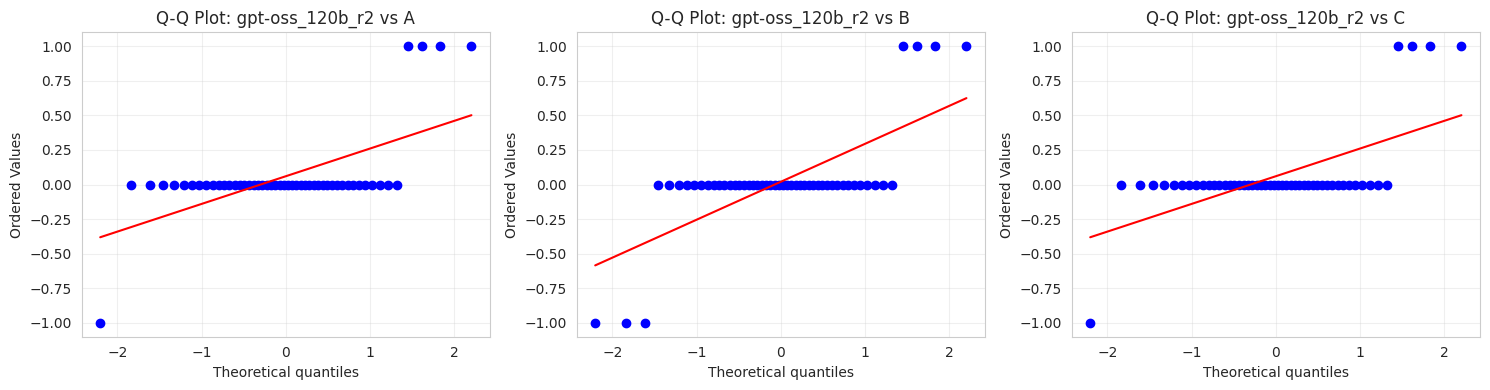


Summary of differences (d = W^h - W^f) for each human:

vs A:
  Mean: 0.0600
  Std: 0.3136
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))

vs B:
  Mean: 0.0200
  Std: 0.3774
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))

vs C:
  Mean: 0.0600
  Std: 0.3136
  Min: -1.0, Max: 1.0
  Unique values: 3 (possible: (-1, 0, 1))


In [17]:
# Visualize normality of differences for the test case
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (human, res) in enumerate(test_results.items()):
    d = np.array(res['W_h']) - np.array(res['W_f'])
    
    # Q-Q plot
    stats.probplot(d, dist="norm", plot=axes[idx])
    axes[idx].set_title(f'Q-Q Plot: {test_llm} vs {human}')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics for differences
print("\nSummary of differences (d = W^h - W^f) for each human:")
for human, res in test_results.items():
    d = np.array(res['W_h']) - np.array(res['W_f'])
    print(f"\nvs {human}:")
    print(f"  Mean: {np.mean(d):.4f}")
    print(f"  Std: {np.std(d, ddof=1):.4f}")
    print(f"  Min: {np.min(d):.1f}, Max: {np.max(d):.1f}")
    print(f"  Unique values: {len(np.unique(d))} (possible: {-1, 0, 1})")


## 5. Individual Category Analysis <a id="5-individual"></a>

We now perform the complete Alt-Test for each commit category (BFC, BPC, PRC, NFC) individually.

In [18]:
def analyze_llms_for_category(category_df, llm_names, human_annotators, epsilon=0.0, alpha=0.05):
    """
    Perform Alt-Test for all LLMs on a single category.
    
    Args:
        category_df: DataFrame with annotations for the category
        llm_names: List of LLM names to test
        human_annotators: List of human annotator names
        epsilon: Cost-benefit hyperparameter (default: 0.0)
        alpha: Significance level (default: 0.05)
    
    Returns:
        DataFrame with results for all LLMs
    """
    results = []
    
    for llm_name in llm_names:
        # Compute advantage probabilities
        adv_probs = compute_advantage_probabilities(
            category_df, llm_name, human_annotators
        )
        
        # Perform alt-test
        alt_test = perform_alt_test(adv_probs, epsilon, alpha)
        
        # Store results
        result_row = {
            'LLM': llm_name,
            'Winning_Rate': alt_test['winning_rate'],
            'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
            'Can_Replace': alt_test['can_replace']
        }
        
        # Add per-human results
        for human in human_annotators:
            res = alt_test['test_results'][human]
            result_row[f'rho_f_vs_{human}'] = res['rho_f']
            result_row[f'p_value_vs_{human}'] = res['p_value']
            result_row[f'rejected_vs_{human}'] = res['rejected']
        
        results.append(result_row)
    
    return pd.DataFrame(results)

In [19]:
# Analyze all categories
category_results = {}
llm_names = list(llm_data.keys())

for category in categories:
    results_df = analyze_llms_for_category(
        unified_data[category],
        llm_names,
        human_annotators,
        epsilon=EPSILON_PRIMARY,
        alpha=ALPHA
    )
    category_results[category] = results_df

In [20]:
# Display results for each category with detailed p-values
for category in categories:
    print(f"\n{'='*100}")
    print(f"{category.upper()} CATEGORY RESULTS")
    print(f"{'='*100}")
    
    df = category_results[category].sort_values('Avg_Advantage_Prob', ascending=False)
    
    # Display summary columns
    display_cols = ['LLM', 'Winning_Rate', 'Avg_Advantage_Prob', 'Can_Replace']
    display(df[display_cols])
    
    # Detailed p-values table
    print(f"\n{'-'*100}")
    print("DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)")
    print(f"{'-'*100}")
    print(f"{'LLM':<30} {'vs A':<20} {'vs B':<20} {'vs C':<20}")
    print(f"{'-'*100}")
    
    for idx, row in df.iterrows():
        p_a = row['p_value_vs_A']
        p_b = row['p_value_vs_B']
        p_c = row['p_value_vs_C']
        
        rej_a = '✓' if row['rejected_vs_A'] else '✗'
        rej_b = '✓' if row['rejected_vs_B'] else '✗'
        rej_c = '✓' if row['rejected_vs_C'] else '✗'
        
        print(f"{row['LLM']:<30} {rej_a} p={p_a:.6f}    {rej_b} p={p_b:.6f}    {rej_c} p={p_c:.6f}")
    
    print(f"{'-'*100}")
    print("Legend: ✓ = H₀ rejected (LLM wins), ✗ = H₀ not rejected")
    
    # Advantage probabilities table
    print(f"\n{'-'*100}")
    print("ADVANTAGE PROBABILITIES (ρ^f): Probability that LLM ≥ Human")
    print(f"{'-'*100}")
    print(f"{'LLM':<30} {'vs A':<15} {'vs B':<15} {'vs C':<15} {'Average':<15}")
    print(f"{'-'*100}")
    
    for idx, row in df.iterrows():
        rho_a = row['rho_f_vs_A']
        rho_b = row['rho_f_vs_B']
        rho_c = row['rho_f_vs_C']
        avg = row['Avg_Advantage_Prob']
        
        print(f"{row['LLM']:<30} {rho_a:.4f}          {rho_b:.4f}          {rho_c:.4f}          {avg:.4f}")
    
    print(f"{'-'*100}")
    
    # Summary statistics
    n_can_replace = df['Can_Replace'].sum()
    print(f"\n📊 SUMMARY: {n_can_replace}/{len(df)} LLMs can replace human annotators (ω ≥ 0.5)")
    print(f"🏆 Best LLM: {df.iloc[0]['LLM']} (ρ = {df.iloc[0]['Avg_Advantage_Prob']:.4f}, ω = {df.iloc[0]['Winning_Rate']:.3f})")
    
    # Show which humans were beaten by best LLM
    best = df.iloc[0]
    beaten = []
    if best['rejected_vs_A']:
        beaten.append('A')
    if best['rejected_vs_B']:
        beaten.append('B')
    if best['rejected_vs_C']:
        beaten.append('C')
    
    if beaten:
        print(f"   Beats humans: {', '.join(beaten)}")
    else:
        print(f"   Does not beat any human (ω < 0.5)")


BFC CATEGORY RESULTS


,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
12,gpt-oss_120b_r2,1.0,0.92,True
4,llama3.1_8b_r1,1.0,0.92,True
11,gemma3_12b_r2,0.0,0.90,False
3,gpt-oss_20b_r1,0.0,0.90,False
17,qwen3-coder_30b_r2,0.0,0.88,False
13,gpt-oss_20b_r2,0.0,0.88,False
14,llama3.1_70b_r2,0.0,0.88,False
6,qwen3-coder_30b_r1,0.0,0.88,False
2,gemma3_12b_r1,0.0,0.88,False
10,deepseek-r1_70b_r2,0.0,0.86,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_120b_r2                ✓ p=0.023950    ✓ p=0.009276    ✓ p=0.023950
llama3.1_8b_r1                 ✓ p=0.023950    ✓ p=0.014908    ✓ p=0.023950
gemma3_12b_r2                  ✗ p=0.124496    ✗ p=0.029406    ✗ p=0.076188
gpt-oss_20b_r1                 ✗ p=0.047187    ✗ p=0.029406    ✗ p=0.076188
qwen3-coder_30b_r2             ✗ p=0.260573    ✗ p=0.070015    ✗ p=0.108571
gpt-oss_20b_r2                 ✗ p=0.168226    ✗ p=0.108571    ✗ p=0.108571
llama3.1_70b_r2                ✗ p=0.260573    ✗ p=0.070015    ✗ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
9,deepseek-r1_14b_r2,0.0,0.820000,False
12,gpt-oss_120b_r2,0.0,0.760000,False
13,gpt-oss_20b_r2,0.0,0.706667,False
1,deepseek-r1_14b_r1,0.0,0.660000,False
11,gemma3_12b_r2,0.0,0.613333,False
16,mistral_7b_r2,0.0,0.606667,False
7,Hermes-4.3-36b_r2,0.0,0.606667,False
8,codellama_13b_r2,0.0,0.600000,False
3,gpt-oss_20b_r1,0.0,0.586667,False
17,qwen3-coder_30b_r2,0.0,0.580000,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
deepseek-r1_14b_r2             ✗ p=0.176733    ✗ p=0.029611    ✗ p=0.176733
gpt-oss_120b_r2                ✗ p=0.219271    ✗ p=0.092842    ✗ p=0.283828
gpt-oss_20b_r2                 ✗ p=0.545306    ✗ p=0.379785    ✗ p=0.718828
deepseek-r1_14b_r1             ✗ p=0.619966    ✗ p=0.316413    ✗ p=0.692152
gemma3_12b_r2                  ✗ p=0.333053    ✗ p=0.395868    ✗ p=0.465326
mistral_7b_r2                  ✗ p=0.611114    ✗ p=0.678966    ✗ p=0.810780
Hermes-4.3-36b_r2              ✗ p=0.685209    ✗ p=0.865977    ✗ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
3,gpt-oss_20b_r1,0.0,0.846667,False
12,gpt-oss_120b_r2,0.0,0.800000,False
9,deepseek-r1_14b_r2,0.0,0.726667,False
7,Hermes-4.3-36b_r2,0.0,0.680000,False
13,gpt-oss_20b_r2,0.0,0.680000,False
1,deepseek-r1_14b_r1,0.0,0.626667,False
17,qwen3-coder_30b_r2,0.0,0.580000,False
6,qwen3-coder_30b_r1,0.0,0.540000,False
14,llama3.1_70b_r2,0.0,0.520000,False
10,deepseek-r1_70b_r2,0.0,0.500000,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_20b_r1                 ✗ p=0.157825    ✗ p=0.060613    ✗ p=0.224335
gpt-oss_120b_r2                ✗ p=0.259385    ✗ p=0.051631    ✗ p=0.342716
deepseek-r1_14b_r2             ✗ p=0.545306    ✗ p=0.368335    ✗ p=0.638386
Hermes-4.3-36b_r2              ✗ p=0.625267    ✗ p=0.459984    ✗ p=0.856545
gpt-oss_20b_r2                 ✗ p=0.912713    ✗ p=0.856545    ✗ p=0.979550
deepseek-r1_14b_r1             ✗ p=0.977035    ✗ p=0.692152    ✗ p=0.954693
qwen3-coder_30b_r2             ✗ p=0.856332    ✗ p=0.740031    ✗ p=0

,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
12,gpt-oss_120b_r2,1.0,1.000000,True
4,llama3.1_8b_r1,1.0,0.980000,True
10,deepseek-r1_70b_r2,1.0,0.980000,True
1,deepseek-r1_14b_r1,1.0,0.960000,True
14,llama3.1_70b_r2,1.0,0.960000,True
7,Hermes-4.3-36b_r2,1.0,0.960000,True
9,deepseek-r1_14b_r2,1.0,0.960000,True
17,qwen3-coder_30b_r2,1.0,0.960000,True
2,gemma3_12b_r1,0.0,0.906667,False
15,llama3.1_8b_r2,0.0,0.900000,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_120b_r2                ✓ p=0.000000    ✓ p=0.000000    ✓ p=0.000000
llama3.1_8b_r1                 ✓ p=0.000002    ✓ p=0.000006    ✓ p=0.000000
deepseek-r1_70b_r2             ✓ p=0.000002    ✓ p=0.000006    ✓ p=0.000000
deepseek-r1_14b_r1             ✓ p=0.000251    ✓ p=0.000263    ✓ p=0.000134
llama3.1_70b_r2                ✓ p=0.000263    ✓ p=0.000163    ✓ p=0.000251
Hermes-4.3-36b_r2              ✓ p=0.000219    ✓ p=0.000263    ✓ p=0.000251
deepseek-r1_14b_r2             ✓ p=0.000251    ✓ p=0.000263    ✓ p=0

## 6. Combined Category Analysis <a id="6-combined"></a>

We now analyze all four categories together, treating the annotation as a 4-dimensional vector.
We use RMSE across all dimensions simultaneously.

In [21]:
def compute_multivariate_rmse_score(f_annotations, other_annotations):
    """
    Compute negative RMSE for multivariate annotations (all 4 categories).
    
    Args:
        f_annotations: 1D array with 4 values [bfc, bpc, prc, nfc]
        other_annotations: 2D array (n_annotators × 4)
    
    Returns:
        Negative RMSE score
    """
    # Compute squared differences across all dimensions
    squared_diffs = np.sum((f_annotations - other_annotations) ** 2, axis=1)
    return -np.sqrt(np.mean(squared_diffs))

def compute_combined_advantage_probabilities(unified_data, llm_name, human_annotators, categories):
    """
    Compute advantage probabilities considering all categories together.
    """
    # Create combined dataset with all categories
    # We need commits that have complete annotations across all categories
    combined_df = unified_data[categories[0]][['hash']].copy()
    
    for cat in categories:
        cat_df = unified_data[cat]
        # Add columns with category suffix
        for col in human_annotators + [llm_name]:
            combined_df = combined_df.merge(
                cat_df[['hash', col]].rename(columns={col: f'{col}_{cat}'}),
                on='hash',
                how='inner'
            )
    
    results = {}
    
    for excluded_human in human_annotators:
        remaining_humans = [h for h in human_annotators if h != excluded_human]
        
        W_f_list = []
        W_h_list = []
        
        for idx, row in combined_df.iterrows():
            # Get multivariate annotations (4D vectors)
            llm_annotation = np.array([row[f'{llm_name}_{cat}'] for cat in categories])
            excluded_annotation = np.array([row[f'{excluded_human}_{cat}'] for cat in categories])
            remaining_annotations = np.array([
                [row[f'{h}_{cat}'] for cat in categories]
                for h in remaining_humans
            ])
            
            # Compute scores
            S_llm = compute_multivariate_rmse_score(llm_annotation, remaining_annotations)
            S_human = compute_multivariate_rmse_score(excluded_annotation, remaining_annotations)
            
            # Indicators
            W_f = 1 if S_llm >= S_human else 0
            W_h = 1 if S_human >= S_llm else 0
            
            W_f_list.append(W_f)
            W_h_list.append(W_h)
        
        results[excluded_human] = {
            'rho_f': np.mean(W_f_list),
            'rho_h': np.mean(W_h_list),
            'W_f': W_f_list,
            'W_h': W_h_list,
            'n_instances': len(W_f_list)
        }
    
    return results

In [22]:
# Perform combined analysis for all LLMs
print(f"Performing combined category analysis (ε={EPSILON_PRIMARY})...\n")
combined_results = []

for llm_name in llm_names:
    
    # Compute advantage probabilities
    adv_probs = compute_combined_advantage_probabilities(
        unified_data, llm_name, human_annotators, categories
    )
    
    # Perform alt-test
    alt_test = perform_alt_test(adv_probs, epsilon=EPSILON_PRIMARY, alpha=ALPHA)
    
    # Store results
    result_row = {
        'LLM': llm_name,
        'Winning_Rate': alt_test['winning_rate'],
        'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
        'Can_Replace': alt_test['can_replace']
    }
    
    for human in human_annotators:
        res = alt_test['test_results'][human]
        result_row[f'rho_f_vs_{human}'] = res['rho_f']
        result_row[f'p_value_vs_{human}'] = res['p_value']
        result_row[f'rejected_vs_{human}'] = res['rejected']
    
    combined_results.append(result_row)

combined_results_df = pd.DataFrame(combined_results).sort_values('Avg_Advantage_Prob', ascending=False)

Performing combined category analysis (ε=0.15)...



In [23]:
# Display combined results with detailed information
print("\n" + "="*100)
print("COMBINED CATEGORY RESULTS (All 4 categories together)")
print("="*100 + "\n")

display_cols = ['LLM', 'Winning_Rate', 'Avg_Advantage_Prob', 'Can_Replace']
display(combined_results_df[display_cols])

# Detailed p-values table
print(f"\n{'-'*100}")
print("DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)")
print(f"{'-'*100}")
print(f"{'LLM':<30} {'vs A':<20} {'vs B':<20} {'vs C':<20}")
print(f"{'-'*100}")

for idx, row in combined_results_df.iterrows():
    p_a = row['p_value_vs_A']
    p_b = row['p_value_vs_B']
    p_c = row['p_value_vs_C']
    
    rej_a = '✓' if row['rejected_vs_A'] else '✗'
    rej_b = '✓' if row['rejected_vs_B'] else '✗'
    rej_c = '✓' if row['rejected_vs_C'] else '✗'
    
    print(f"{row['LLM']:<30} {rej_a} p={p_a:.6f}    {rej_b} p={p_b:.6f}    {rej_c} p={p_c:.6f}")

print(f"{'-'*100}")
print("Legend: ✓ = H₀ rejected (LLM wins), ✗ = H₀ not rejected")

# Advantage probabilities table
print(f"\n{'-'*100}")
print("ADVANTAGE PROBABILITIES (ρ^f): Probability that LLM ≥ Human")
print(f"{'-'*100}")
print(f"{'LLM':<30} {'vs A':<15} {'vs B':<15} {'vs C':<15} {'Average':<15}")
print(f"{'-'*100}")

for idx, row in combined_results_df.iterrows():
    rho_a = row['rho_f_vs_A']
    rho_b = row['rho_f_vs_B']
    rho_c = row['rho_f_vs_C']
    avg = row['Avg_Advantage_Prob']
    
    print(f"{row['LLM']:<30} {rho_a:.4f}          {rho_b:.4f}          {rho_c:.4f}          {avg:.4f}")

print(f"{'-'*100}")

n_can_replace = combined_results_df['Can_Replace'].sum()
print(f"\n📊 SUMMARY: {n_can_replace}/{len(combined_results_df)} LLMs can replace human annotators (ω ≥ 0.5)")
print(f"🏆 Best LLM: {combined_results_df.iloc[0]['LLM']} (ρ = {combined_results_df.iloc[0]['Avg_Advantage_Prob']:.4f}, ω = {combined_results_df.iloc[0]['Winning_Rate']:.3f})")

# Show which humans were beaten by best LLM
best = combined_results_df.iloc[0]
beaten = []
if best['rejected_vs_A']:
    beaten.append('A')
if best['rejected_vs_B']:
    beaten.append('B')
if best['rejected_vs_C']:
    beaten.append('C')

if beaten:
    print(f"   Beats humans: {', '.join(beaten)}")
else:
    print(f"   Does not beat any human (ω < 0.5)")

# Statistical significance summary
print(f"\n{'-'*100}")
print("STATISTICAL SIGNIFICANCE SUMMARY")
print(f"{'-'*100}")
print(f"Epsilon (ε):             {EPSILON_PRIMARY}")
print(f"Significance level (α):  {ALPHA}")
print(f"Multiple testing:        Benjamini-Yekutieli FDR correction")
print(f"Statistical test:        Wilcoxon signed-rank (non-parametric, for non-normal differences)")
print(f"\nInterpretation of results:")
print(f"  - ✓ (rejected): p < {ALPHA} after BY correction → LLM significantly better than human")
print(f"  - ✗ (not rejected): p ≥ {ALPHA} → Insufficient evidence that LLM is better")
print(f"  - Winning Rate (ω): Proportion of humans beaten (need ω ≥ 0.5 to replace)")
print(f"{'-'*100}")


COMBINED CATEGORY RESULTS (All 4 categories together)



,LLM,Winning_Rate,Avg_Advantage_Prob,Can_Replace
12,gpt-oss_120b_r2,0.0,0.646667,False
9,deepseek-r1_14b_r2,0.0,0.540000,False
3,gpt-oss_20b_r1,0.0,0.486667,False
13,gpt-oss_20b_r2,0.0,0.480000,False
6,qwen3-coder_30b_r1,0.0,0.440000,False
7,Hermes-4.3-36b_r2,0.0,0.440000,False
1,deepseek-r1_14b_r1,0.0,0.406667,False
17,qwen3-coder_30b_r2,0.0,0.386667,False
14,llama3.1_70b_r2,0.0,0.386667,False
10,deepseek-r1_70b_r2,0.0,0.386667,False



----------------------------------------------------------------------------------------------------
DETAILED P-VALUES AND REJECTION STATUS (after Benjamini-Yekutieli correction)
----------------------------------------------------------------------------------------------------
LLM                            vs A                 vs B                 vs C                
----------------------------------------------------------------------------------------------------
gpt-oss_120b_r2                ✗ p=0.461547    ✗ p=0.213088    ✗ p=0.876364
deepseek-r1_14b_r2             ✗ p=0.971647    ✗ p=0.673314    ✗ p=0.994430
gpt-oss_20b_r1                 ✗ p=0.914709    ✗ p=0.955913    ✗ p=0.995470
gpt-oss_20b_r2                 ✗ p=0.981460    ✗ p=0.938083    ✗ p=0.999991
qwen3-coder_30b_r1             ✗ p=0.816956    ✗ p=0.848908    ✗ p=0.995221
Hermes-4.3-36b_r2              ✗ p=0.823838    ✗ p=0.960617    ✗ p=0.995221
deepseek-r1_14b_r1             ✗ p=0.992432    ✗ p=0.887517    ✗ p=0

## 7. Visualizations <a id="7-visualizations"></a>

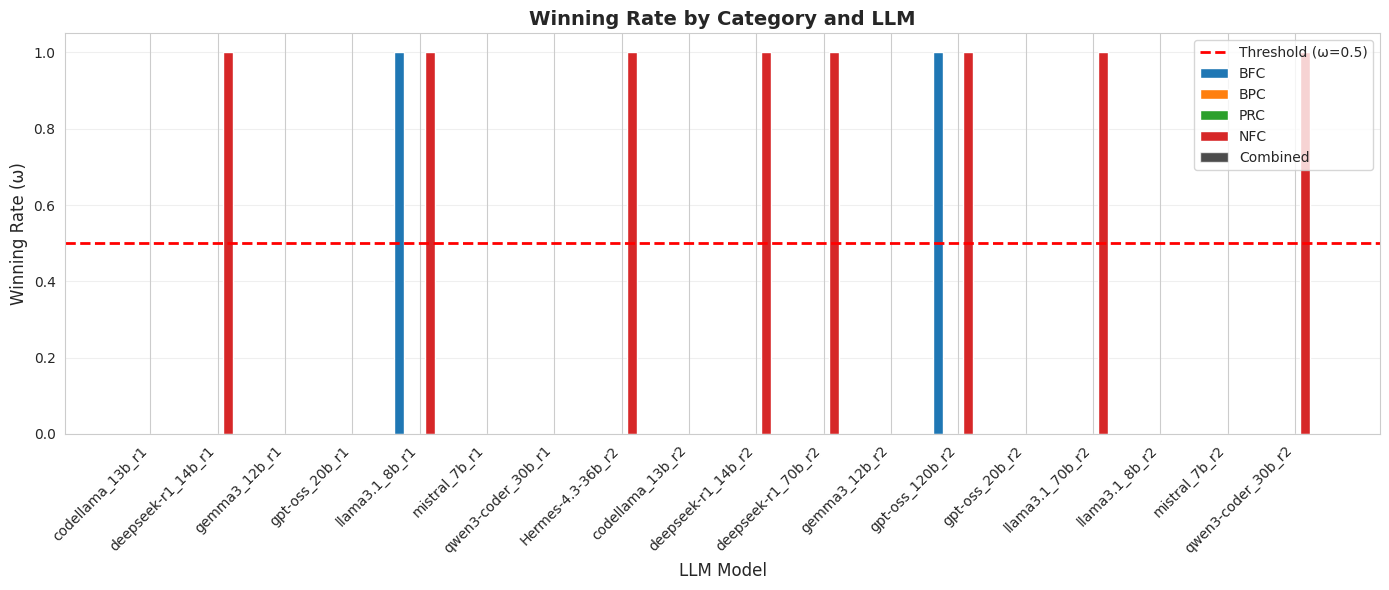

In [24]:
# 1. Winning Rate comparison across categories
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(llm_names))
width = 0.15

for i, category in enumerate(categories):
    df = category_results[category].set_index('LLM').loc[llm_names]
    ax.bar(x + i*width, df['Winning_Rate'], width, label=category.upper())

# Add combined results
combined_df = combined_results_df.set_index('LLM').loc[llm_names]
ax.bar(x + 4*width, combined_df['Winning_Rate'], width, label='Combined', color='black', alpha=0.7)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (ω=0.5)')
ax.set_xlabel('LLM Model', fontsize=12)
ax.set_ylabel('Winning Rate (ω)', fontsize=12)
ax.set_title('Winning Rate by Category and LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x + 2*width)
ax.set_xticklabels(llm_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

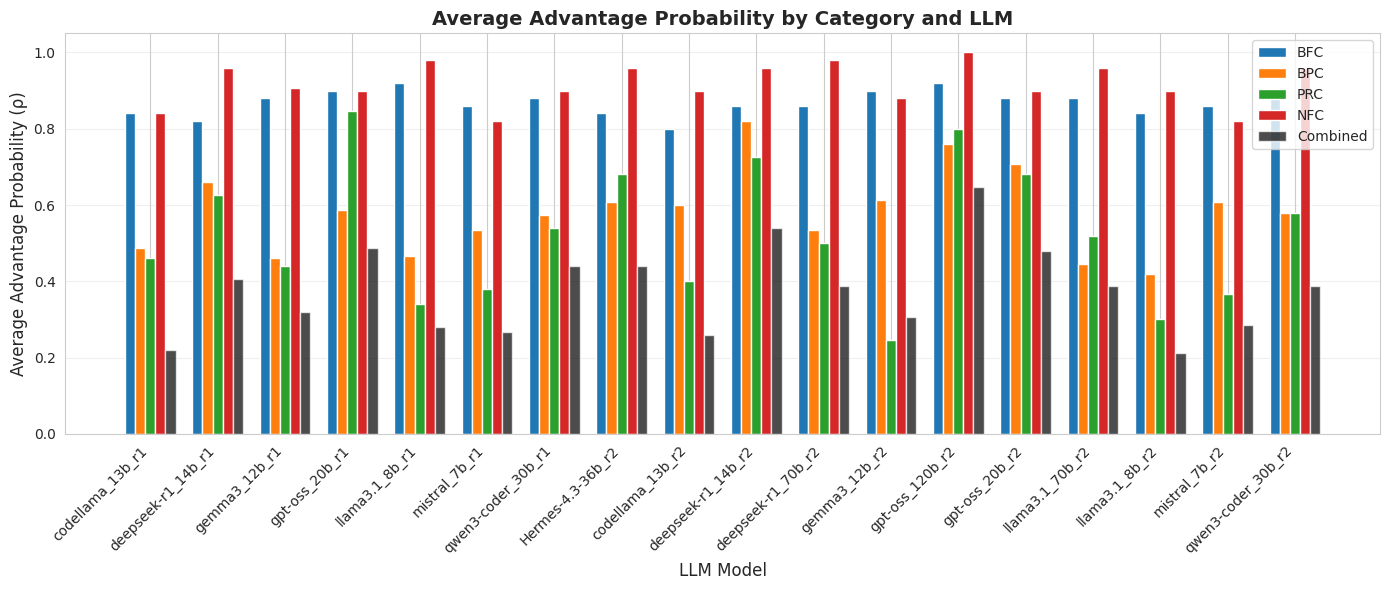

In [25]:
# 2. Average Advantage Probability (ρ) comparison
fig, ax = plt.subplots(figsize=(14, 6))

for i, category in enumerate(categories):
    df = category_results[category].set_index('LLM').loc[llm_names]
    ax.bar(x + i*width, df['Avg_Advantage_Prob'], width, label=category.upper())

combined_df = combined_results_df.set_index('LLM').loc[llm_names]
ax.bar(x + 4*width, combined_df['Avg_Advantage_Prob'], width, label='Combined', color='black', alpha=0.7)

ax.set_xlabel('LLM Model', fontsize=12)
ax.set_ylabel('Average Advantage Probability (ρ)', fontsize=12)
ax.set_title('Average Advantage Probability by Category and LLM', fontsize=14, fontweight='bold')
ax.set_xticks(x + 2*width)
ax.set_xticklabels(llm_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

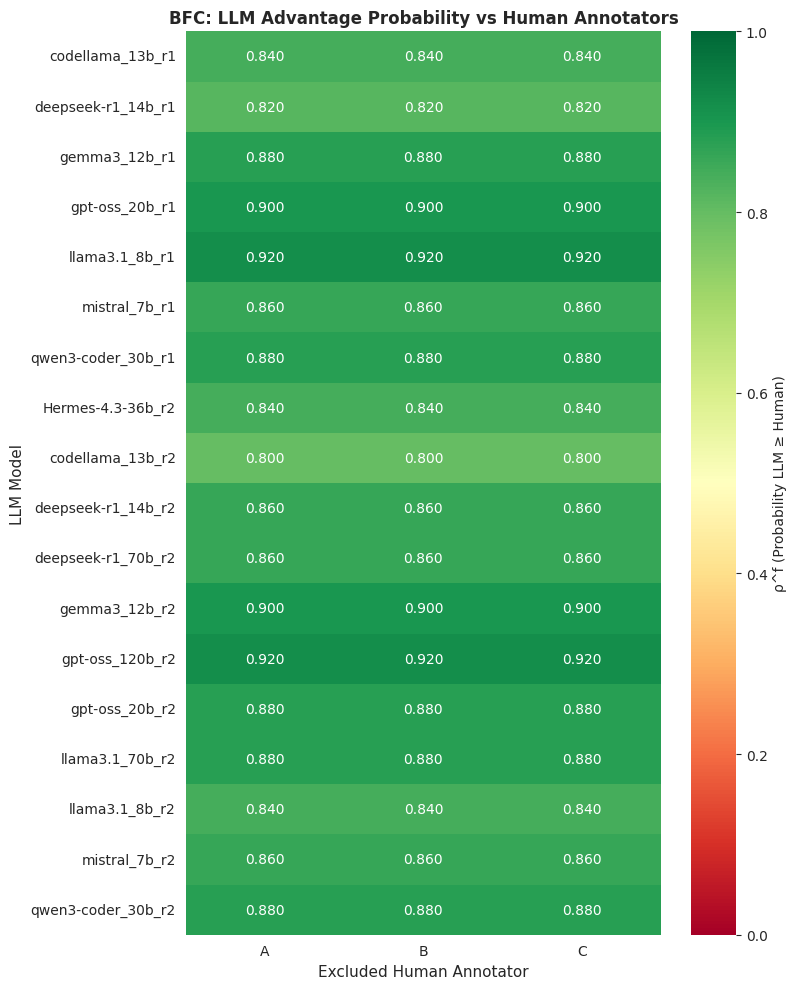

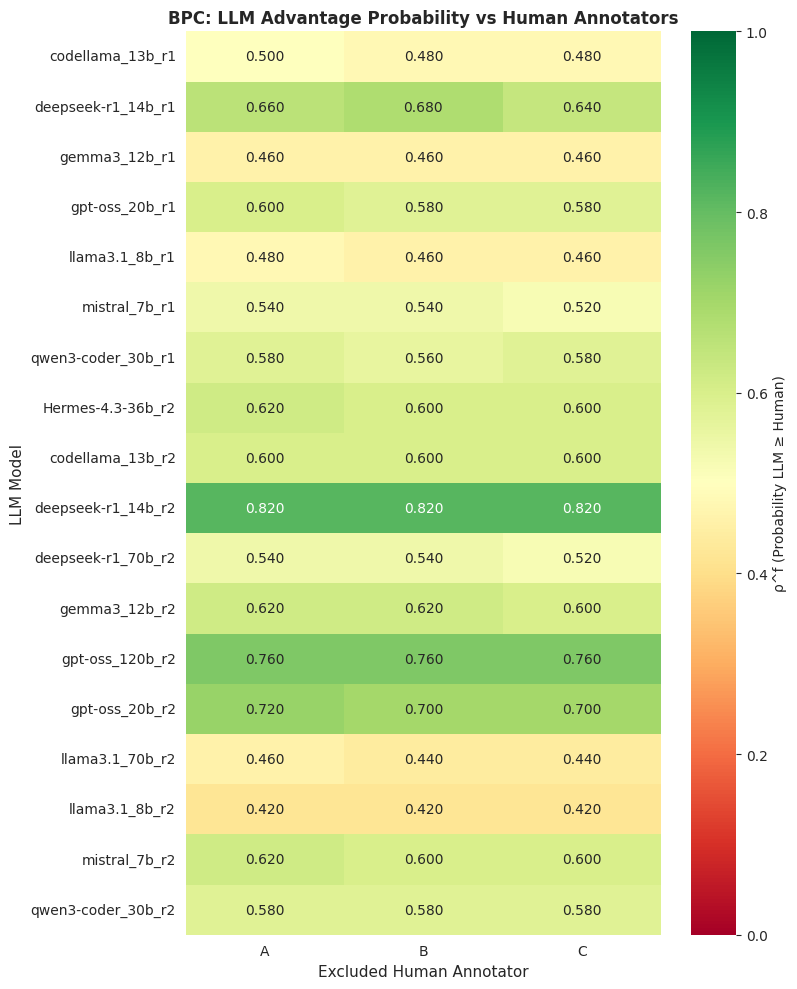

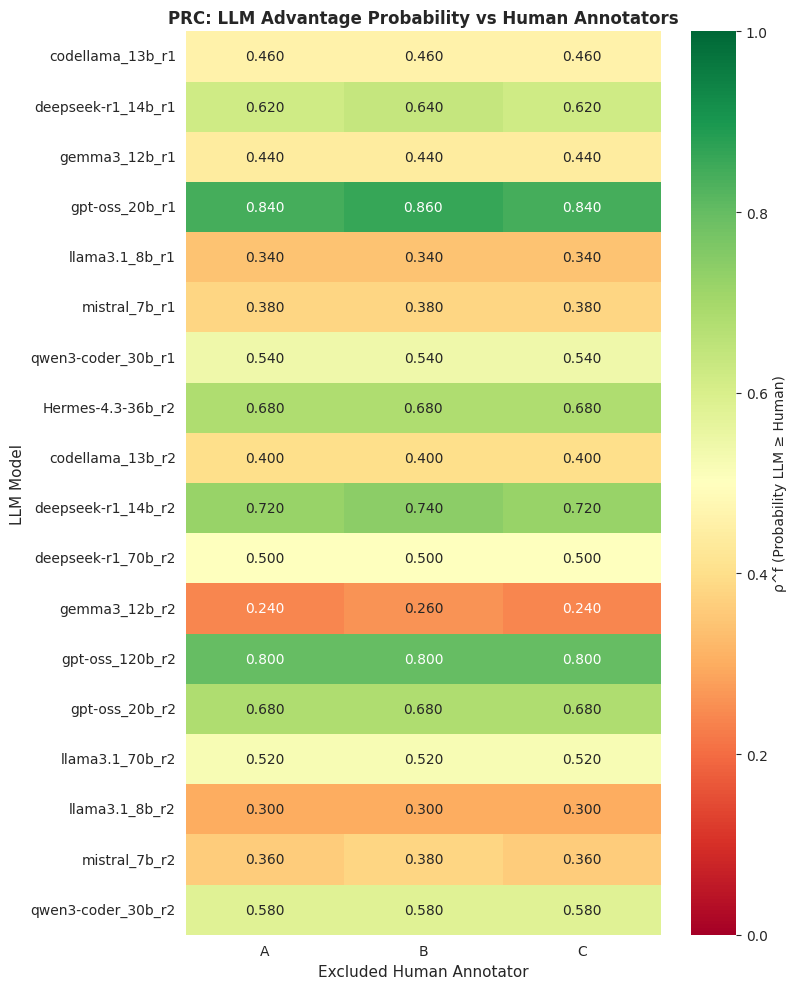

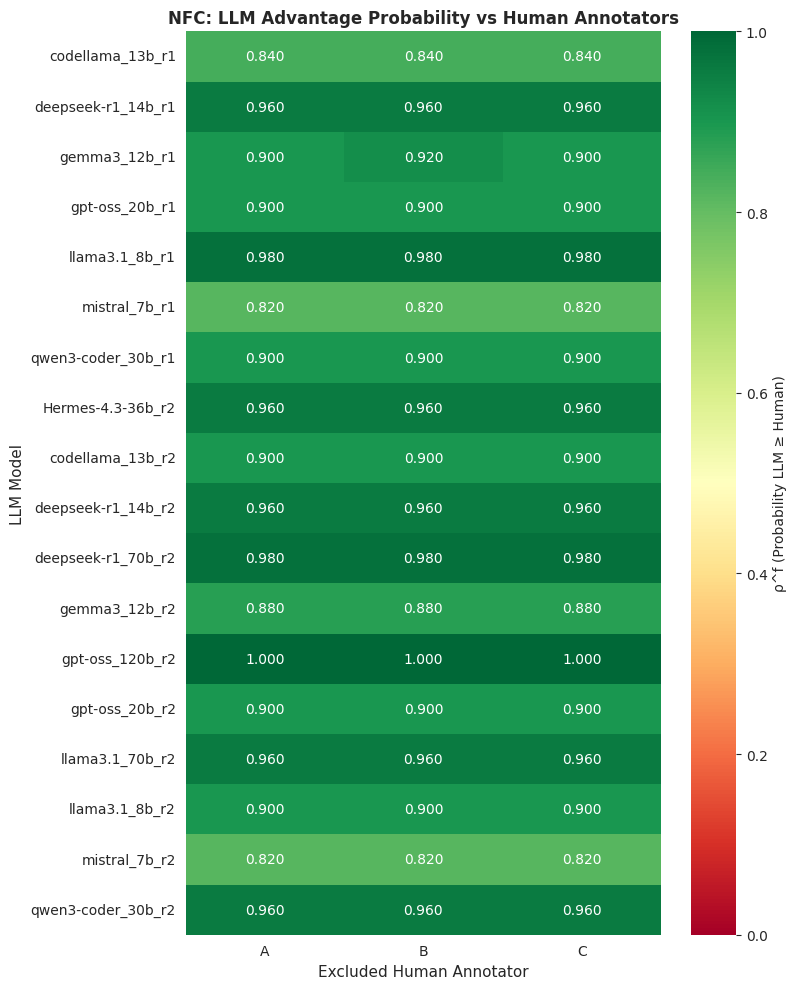

In [26]:
# 3. Heatmap of ρ^f (LLM advantage probability) vs human annotators
for category in categories:
    fig, ax = plt.subplots(figsize=(8, 10))
    
    df = category_results[category]
    
    # Create matrix: rows=LLMs, cols=human annotators
    matrix = np.zeros((len(llm_names), len(human_annotators)))
    for i, llm in enumerate(llm_names):
        for j, human in enumerate(human_annotators):
            matrix[i, j] = df[df['LLM'] == llm][f'rho_f_vs_{human}'].values[0]
    
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
                xticklabels=human_annotators, yticklabels=llm_names,
                cbar_kws={'label': 'ρ^f (Probability LLM ≥ Human)'}, ax=ax)
    
    ax.set_title(f'{category.upper()}: LLM Advantage Probability vs Human Annotators', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Excluded Human Annotator', fontsize=11)
    ax.set_ylabel('LLM Model', fontsize=11)
    plt.tight_layout()
    plt.show()

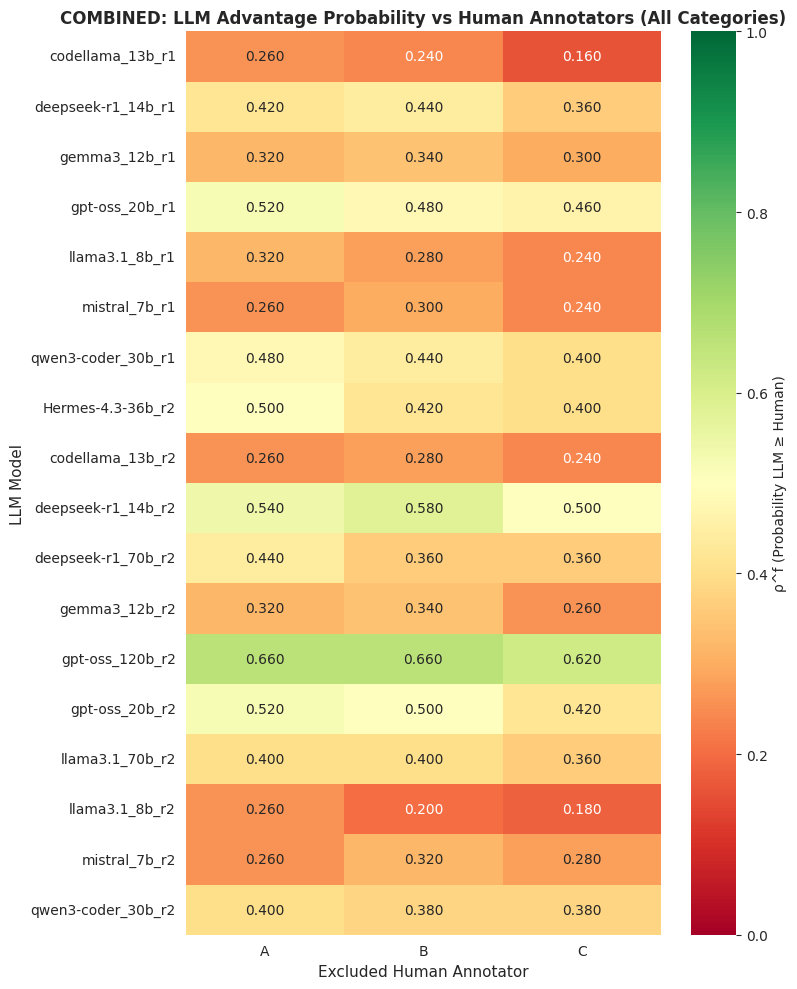

In [27]:
# 4. Combined category heatmap
fig, ax = plt.subplots(figsize=(8, 10))

matrix = np.zeros((len(llm_names), len(human_annotators)))
for i, llm in enumerate(llm_names):
    for j, human in enumerate(human_annotators):
        matrix[i, j] = combined_results_df[combined_results_df['LLM'] == llm][f'rho_f_vs_{human}'].values[0]

sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=human_annotators, yticklabels=llm_names,
            cbar_kws={'label': 'ρ^f (Probability LLM ≥ Human)'}, ax=ax)

ax.set_title('COMBINED: LLM Advantage Probability vs Human Annotators (All Categories)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Excluded Human Annotator', fontsize=11)
ax.set_ylabel('LLM Model', fontsize=11)
plt.tight_layout()
plt.show()

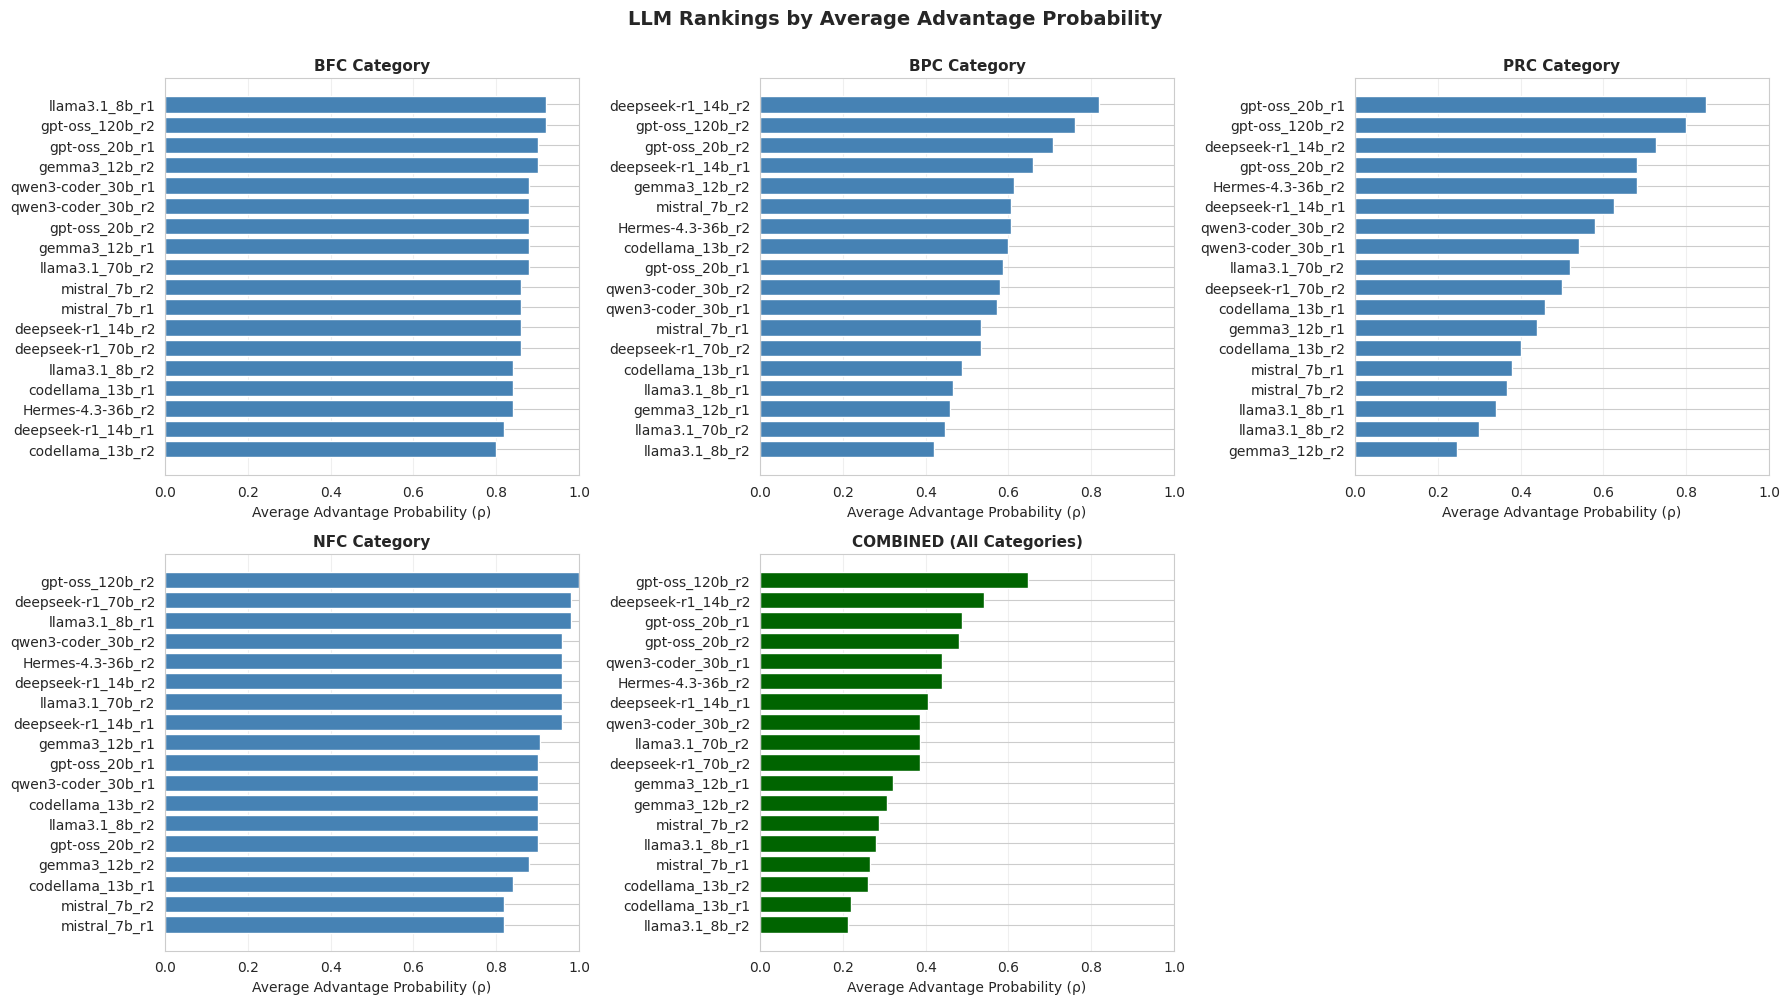

In [28]:
# 5. LLM Ranking by Average Advantage Probability
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Individual categories
for i, category in enumerate(categories):
    df = category_results[category].sort_values('Avg_Advantage_Prob', ascending=True)
    axes[i].barh(df['LLM'], df['Avg_Advantage_Prob'], color='steelblue')
    axes[i].set_xlabel('Average Advantage Probability (ρ)', fontsize=10)
    axes[i].set_title(f'{category.upper()} Category', fontsize=11, fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)
    axes[i].set_xlim([0, 1])

# Combined
df_combined = combined_results_df.sort_values('Avg_Advantage_Prob', ascending=True)
axes[4].barh(df_combined['LLM'], df_combined['Avg_Advantage_Prob'], color='darkgreen')
axes[4].set_xlabel('Average Advantage Probability (ρ)', fontsize=10)
axes[4].set_title('COMBINED (All Categories)', fontsize=11, fontweight='bold')
axes[4].grid(axis='x', alpha=0.3)
axes[4].set_xlim([0, 1])

# Hide the last subplot
axes[5].axis('off')

plt.suptitle('LLM Rankings by Average Advantage Probability', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 8. Epsilon Sensitivity Analysis <a id="8-sensitivity"></a>

We now test how the results change with different epsilon values to validate our choice of ε=0.15.

In [29]:
# Perform sensitivity analysis with different epsilon values BY CATEGORY
print("Performing epsilon sensitivity analysis by category...\n")

sensitivity_results = []

for category in categories:
    print(f"\n{'='*60}")
    print(f"Category: {category.upper()}")
    print(f"{'='*60}")
    
    for eps in EPSILON_SENSITIVITY:
        print(f"  Testing ε = {eps}")
        
        # Test on THIS category
        for llm_name in llm_names:
            adv_probs = compute_advantage_probabilities(
                unified_data[category], llm_name, human_annotators
            )
            alt_test = perform_alt_test(adv_probs, epsilon=eps, alpha=ALPHA)
            
            sensitivity_results.append({
                'category': category,
                'epsilon': eps,
                'LLM': llm_name,
                'Winning_Rate': alt_test['winning_rate'],
                'Avg_Advantage_Prob': alt_test['avg_advantage_prob'],
                'Can_Replace': alt_test['can_replace']
            })
        
        n_can_replace = sum(
            r['Can_Replace'] for r in sensitivity_results 
            if r['epsilon']==eps and r['category']==category
        )
        print(f"    {category.upper()}: {n_can_replace}/{len(llm_names)} LLMs can replace")

sensitivity_df = pd.DataFrame(sensitivity_results)

Performing epsilon sensitivity analysis by category...


Category: BFC
  Testing ε = 0.0
    BFC: 0/18 LLMs can replace
  Testing ε = 0.05
    BFC: 0/18 LLMs can replace
  Testing ε = 0.1
    BFC: 0/18 LLMs can replace
  Testing ε = 0.15
    BFC: 2/18 LLMs can replace
  Testing ε = 0.2
    BFC: 6/18 LLMs can replace

Category: BPC
  Testing ε = 0.0
    BPC: 0/18 LLMs can replace
  Testing ε = 0.05
    BPC: 0/18 LLMs can replace
  Testing ε = 0.1
    BPC: 0/18 LLMs can replace
  Testing ε = 0.15
    BPC: 0/18 LLMs can replace
  Testing ε = 0.2
    BPC: 0/18 LLMs can replace

Category: PRC
  Testing ε = 0.0
    PRC: 0/18 LLMs can replace
  Testing ε = 0.05
    PRC: 0/18 LLMs can replace
  Testing ε = 0.1
    PRC: 0/18 LLMs can replace
  Testing ε = 0.15
    PRC: 0/18 LLMs can replace
  Testing ε = 0.2
    PRC: 0/18 LLMs can replace

Category: NFC
  Testing ε = 0.0
    NFC: 0/18 LLMs can replace
  Testing ε = 0.05
    NFC: 1/18 LLMs can replace
  Testing ε = 0.1
    NFC: 8/18 LLMs can rep

In [30]:
# Display sensitivity results table BY CATEGORY
print("\n" + "="*80)
print("EPSILON SENSITIVITY ANALYSIS RESULTS BY CATEGORY")
print("="*80)

for category in categories:
    print(f"\n{'█'*80}")
    print(f"CATEGORY: {category.upper()}")
    print(f"{'█'*80}")
    
    for eps in EPSILON_SENSITIVITY:
        print(f"\n{'─'*80}")
        print(f"ε = {eps}")
        print(f"{'─'*80}")
        
        eps_results = sensitivity_df[
            (sensitivity_df['epsilon'] == eps) & 
            (sensitivity_df['category'] == category)
        ].sort_values('Avg_Advantage_Prob', ascending=False)
        
        for idx, row in eps_results.iterrows():
            status = "✓ CAN" if row['Can_Replace'] else "✗ CANNOT"
            print(f"{status:12s} | {row['LLM']:25s} | ω={row['Winning_Rate']:.3f} | ρ={row['Avg_Advantage_Prob']:.3f}")
        
        n_pass = eps_results['Can_Replace'].sum()
        print(f"\nSummary: {n_pass}/{len(llm_names)} LLMs can replace humans in {category.upper()} with ε={eps}")

print("\n" + "="*80)


EPSILON SENSITIVITY ANALYSIS RESULTS BY CATEGORY

████████████████████████████████████████████████████████████████████████████████
CATEGORY: BFC
████████████████████████████████████████████████████████████████████████████████

────────────────────────────────────────────────────────────────────────────────
ε = 0.0
────────────────────────────────────────────────────────────────────────────────
✗ CANNOT     | gpt-oss_120b_r2           | ω=0.000 | ρ=0.920
✗ CANNOT     | llama3.1_8b_r1            | ω=0.000 | ρ=0.920
✗ CANNOT     | gemma3_12b_r2             | ω=0.000 | ρ=0.900
✗ CANNOT     | gpt-oss_20b_r1            | ω=0.000 | ρ=0.900
✗ CANNOT     | qwen3-coder_30b_r2        | ω=0.000 | ρ=0.880
✗ CANNOT     | gpt-oss_20b_r2            | ω=0.000 | ρ=0.880
✗ CANNOT     | llama3.1_70b_r2           | ω=0.000 | ρ=0.880
✗ CANNOT     | qwen3-coder_30b_r1        | ω=0.000 | ρ=0.880
✗ CANNOT     | gemma3_12b_r1             | ω=0.000 | ρ=0.880
✗ CANNOT     | deepseek-r1_70b_r2        | ω=0.000 | 

## 9. Conclusions and Interpretation <a id="9-conclusions"></a>

In [31]:
# Generate comprehensive summary
print("="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)
print(f"\n**Epsilon (ε) Used: {EPSILON_PRIMARY}** (skilled annotators)")
print(f"Significance Level (α): {ALPHA}")
print(f"Statistical Test: Bootstrap (resampling-based)")

print("\n1. OVERALL RESULTS (Combined Categories)")
print("-" * 80)
for idx, row in combined_results_df.iterrows():
    status = "✓ CAN REPLACE" if row['Can_Replace'] else "✗ CANNOT REPLACE"
    print(f"{status:20s} | {row['LLM']:25s} | ω={row['Winning_Rate']:.3f} | ρ={row['Avg_Advantage_Prob']:.3f}")

print("\n2. CATEGORY-SPECIFIC RESULTS")
print("-" * 80)
for category in categories:
    print(f"\n{category.upper()} Category:")
    df = category_results[category]
    can_replace = df[df['Can_Replace'] == True]
    print(f"  {len(can_replace)}/{len(df)} LLMs can replace humans")
    if len(can_replace) > 0:
        best = can_replace.sort_values('Avg_Advantage_Prob', ascending=False).iloc[0]
        print(f"  Best: {best['LLM']} (ρ={best['Avg_Advantage_Prob']:.3f})")

print("\n3. BEST PERFORMING LLMs (by Average Advantage Probability)")
print("-" * 80)
top_3 = combined_results_df.head(3)
for rank, (idx, row) in enumerate(top_3.iterrows(), 1):
    print(f"  #{rank}. {row['LLM']:30s} ρ={row['Avg_Advantage_Prob']:.3f}")

print("\n4. STATISTICAL METHODOLOGY")
print("-" * 80)
print("  Bootstrap Test with epsilon-adjusted hypothesis:")
print(f"    H₀: E[d] ≥ ε (LLM disadvantage ≥ {EPSILON_PRIMARY})")
print(f"    H₁: E[d] < ε (LLM disadvantage < {EPSILON_PRIMARY})")
print("  where d = ρʰ - ρᶠ (difference in annotation quality)")
print("\n  Bootstrap resampling (10,000 iterations) to estimate E[d] distribution")
print("  P-value = proportion of bootstrap samples where E[d] ≥ ε")
print("  Benjamini-Yekutieli FDR correction for multiple comparisons")

print("\n5. INTERPRETATION")
print("-" * 80)
n_can_replace = combined_results_df['Can_Replace'].sum()
if n_can_replace > 0:
    print(f"✓ {n_can_replace} LLM(s) achieved winning rate ω ≥ 0.5 with ε={EPSILON_PRIMARY}")
    print("  These models can statistically justify replacing a human annotator.")
    print("\n  Winning Rate (ω) interpretation:")
    print("  - ω = proportion of human annotators that the LLM 'beats' in the Sign Test")
    print("  - ω ≥ 0.5 means the LLM wins against at least half of the humans")
    print("\n  Average Advantage Probability (ρ) interpretation:")
    print("  - ρ = probability that LLM annotations are ≥ quality of a random human")
    print("  - Higher ρ indicates better overall alignment with human consensus")
else:
    print(f"✗ No LLMs achieved winning rate ω ≥ 0.5 with ε={EPSILON_PRIMARY}")
    print("  None of the tested models can fully replace a human annotator.")
    print(f"  However, best model ({combined_results_df.iloc[0]['LLM']}) has ρ={combined_results_df.iloc[0]['Avg_Advantage_Prob']:.3f}")
    print(f"\n  Note: Try increasing ε to {EPSILON_PRIMARY + 0.05} for a more lenient threshold")

print("\n6. CATEGORY-SPECIFIC STRENGTHS")
print("-" * 80)
for llm in llm_names:
    strengths = []
    for cat in categories:
        df = category_results[cat]
        row = df[df['LLM'] == llm].iloc[0]
        if row['Can_Replace']:
            strengths.append(cat.upper())
    
    if strengths:
        print(f"  {llm:30s}: Strong in {', '.join(strengths)}")

print("\n7. EPSILON SENSITIVITY ANALYSIS")
print("-" * 80)
print(f"  Primary ε = {EPSILON_PRIMARY} (skilled annotators)")
print(f"  Tested range: {min(EPSILON_SENSITIVITY)} to {max(EPSILON_SENSITIVITY)}")
print("  - Analyzed sensitivity BY CATEGORY (BFC, BPC, PRC, NFC)")
print("  - Shows how threshold affects replacement decision per commit type")
print("  - Accounts for cost/time savings of using LLMs vs human annotators")
print("  - See Section 8 for detailed category-specific sensitivity results")

print("\n8. LIMITATIONS & CONSIDERATIONS")
print("-" * 80)
print("  - Sample size: 50 commits (limited statistical power)")
print("  - Only 3 human annotators (small baseline)")
print(f"  - Epsilon (ε) = {EPSILON_PRIMARY} chosen for skilled annotators")
print("  - Bootstrap test is non-parametric (doesn't assume normal distribution)")
print("  - Results specific to Linux kernel commits")
print("  - Different contexts may yield different results")
print("  - Category-specific performance varies (see sensitivity analysis)")
print("  - Consider domain-specific validation before deployment")

print("\n9. KEY FINDINGS")
print("-" * 80)
print("  ✓ Bootstrap test provides robust non-parametric hypothesis testing")
print("  ✓ Epsilon has meaningful gradation (0.05 ≠ 0.15) unlike discrete counting methods")
print("  ✓ Category-specific analysis reveals performance varies by commit type")
print("  ✓ Sensitivity analysis shows threshold impact differs across categories")
print("  ✓ FDR correction ensures controlled false discovery rate")

print("\n" + "="*80)
print("END OF ANALYSIS")
print("="*80)

COMPREHENSIVE ANALYSIS SUMMARY

**Epsilon (ε) Used: 0.15** (skilled annotators)
Significance Level (α): 0.05
Statistical Test: Bootstrap (resampling-based)

1. OVERALL RESULTS (Combined Categories)
--------------------------------------------------------------------------------
✗ CANNOT REPLACE     | gpt-oss_120b_r2           | ω=0.000 | ρ=0.647
✗ CANNOT REPLACE     | deepseek-r1_14b_r2        | ω=0.000 | ρ=0.540
✗ CANNOT REPLACE     | gpt-oss_20b_r1            | ω=0.000 | ρ=0.487
✗ CANNOT REPLACE     | gpt-oss_20b_r2            | ω=0.000 | ρ=0.480
✗ CANNOT REPLACE     | qwen3-coder_30b_r1        | ω=0.000 | ρ=0.440
✗ CANNOT REPLACE     | Hermes-4.3-36b_r2         | ω=0.000 | ρ=0.440
✗ CANNOT REPLACE     | deepseek-r1_14b_r1        | ω=0.000 | ρ=0.407
✗ CANNOT REPLACE     | qwen3-coder_30b_r2        | ω=0.000 | ρ=0.387
✗ CANNOT REPLACE     | llama3.1_70b_r2           | ω=0.000 | ρ=0.387
✗ CANNOT REPLACE     | deepseek-r1_70b_r2        | ω=0.000 | ρ=0.387
✗ CANNOT REPLACE     | gemma3_1

# Appendix A: Histograms of W_h, W_f, and differences for ALL LLMs and ALL humans on BFC category


LLM: codellama_13b_r1



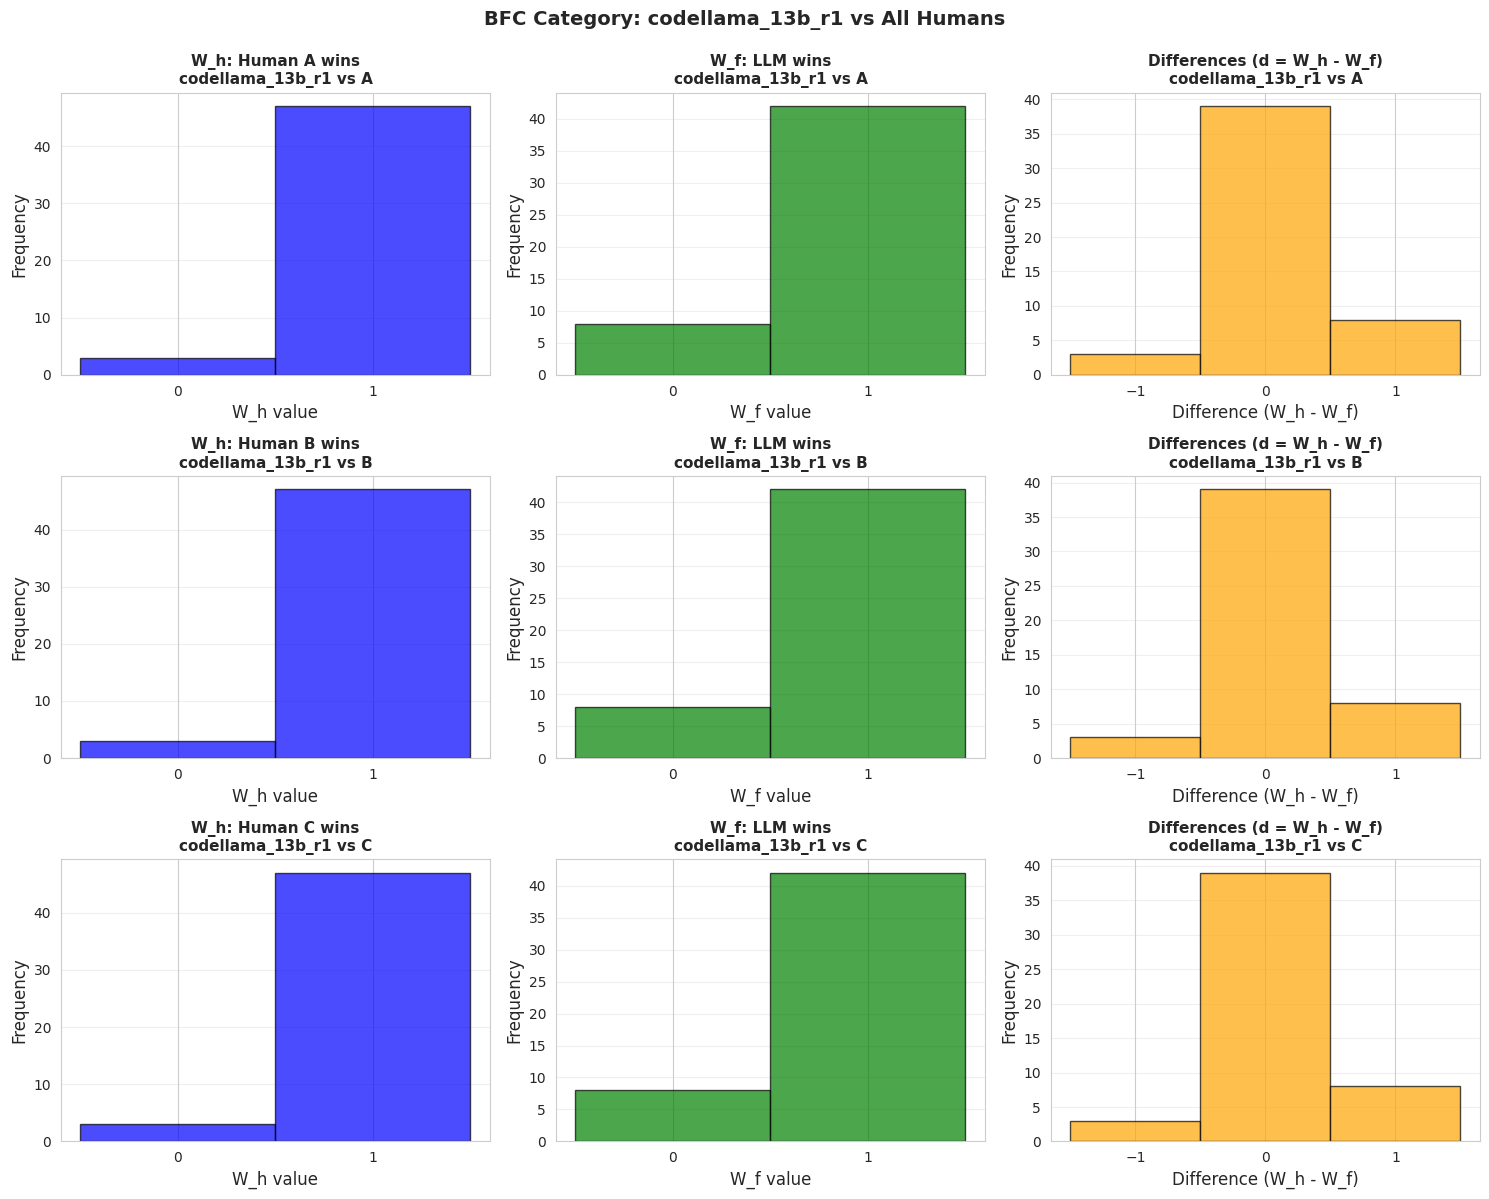


SUMMARY STATISTICS: codellama_13b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           39 commits ( 78.0%)
    d =  1 (Human better):   8 commits ( 16.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           39 commits ( 78.0%)
    d =  1 (Human better):   8 commits ( 16.0%)

vs Human C:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  

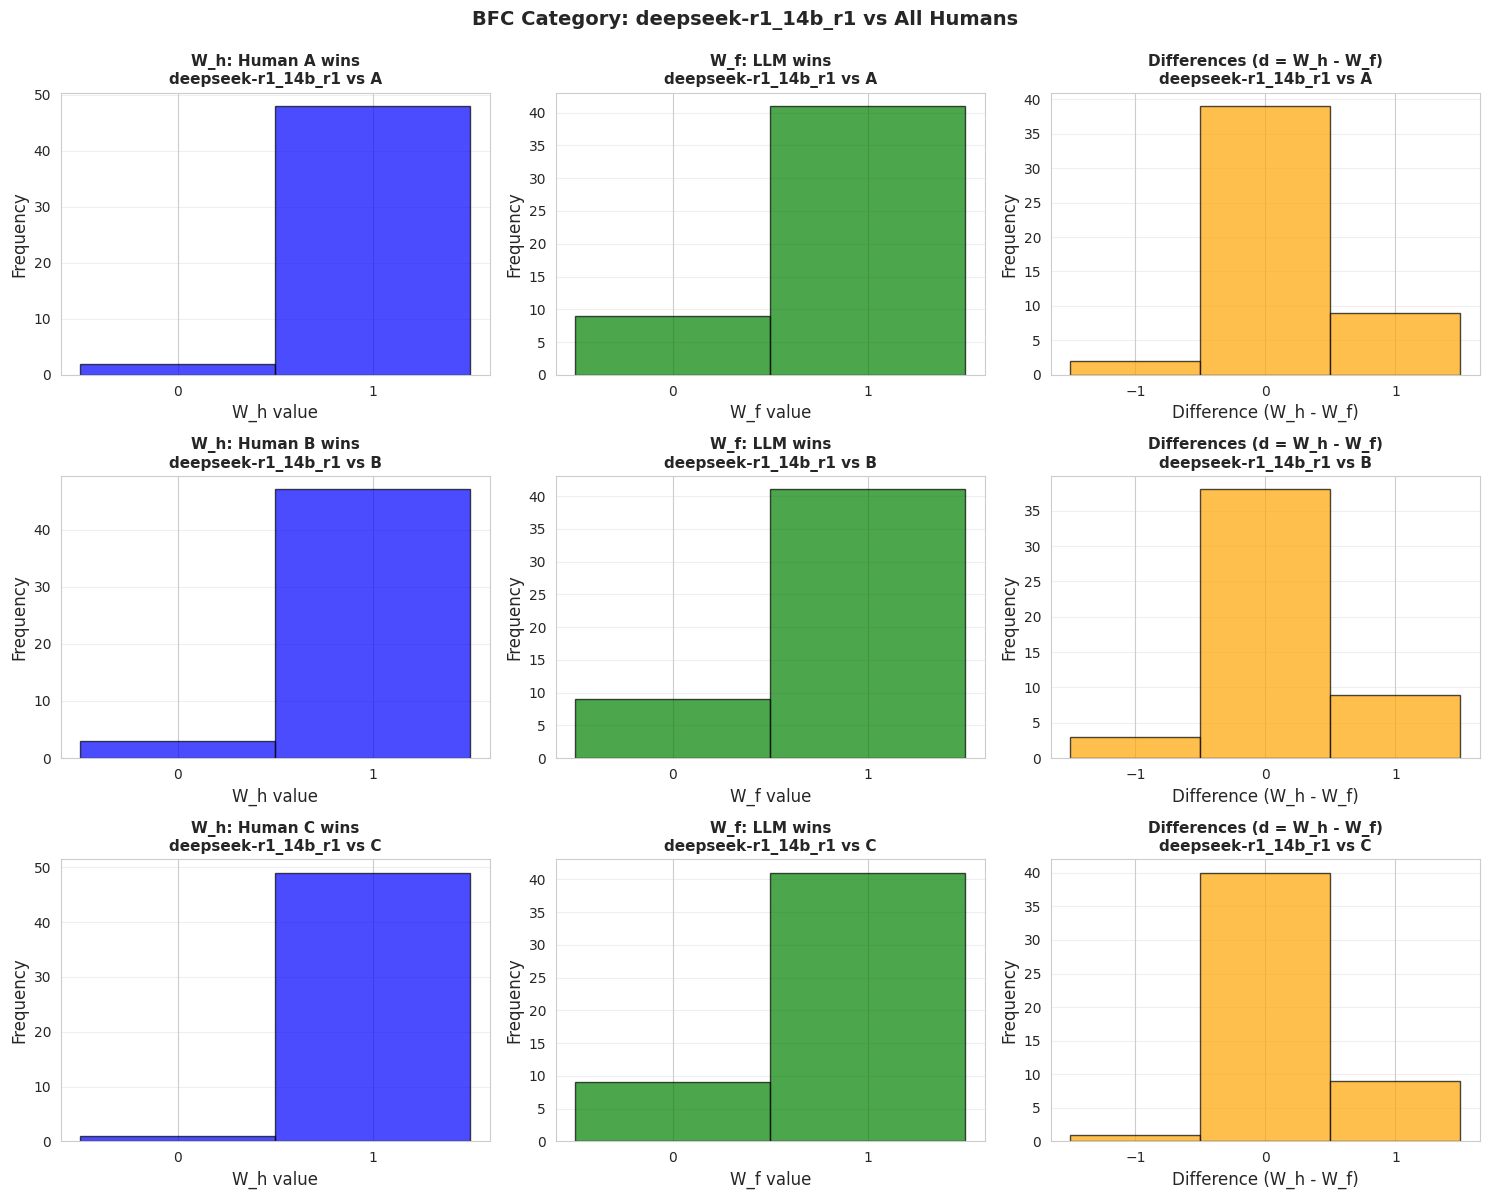


SUMMARY STATISTICS: deepseek-r1_14b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    41/50 commits ( 82.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           39 commits ( 78.0%)
    d =  1 (Human better):   9 commits ( 18.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    41/50 commits ( 82.0%)
  Ties:             -38/50 commits (-76.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           38 commits ( 76.0%)
    d =  1 (Human better):   9 commits ( 18.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    41/50 commits ( 82.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =

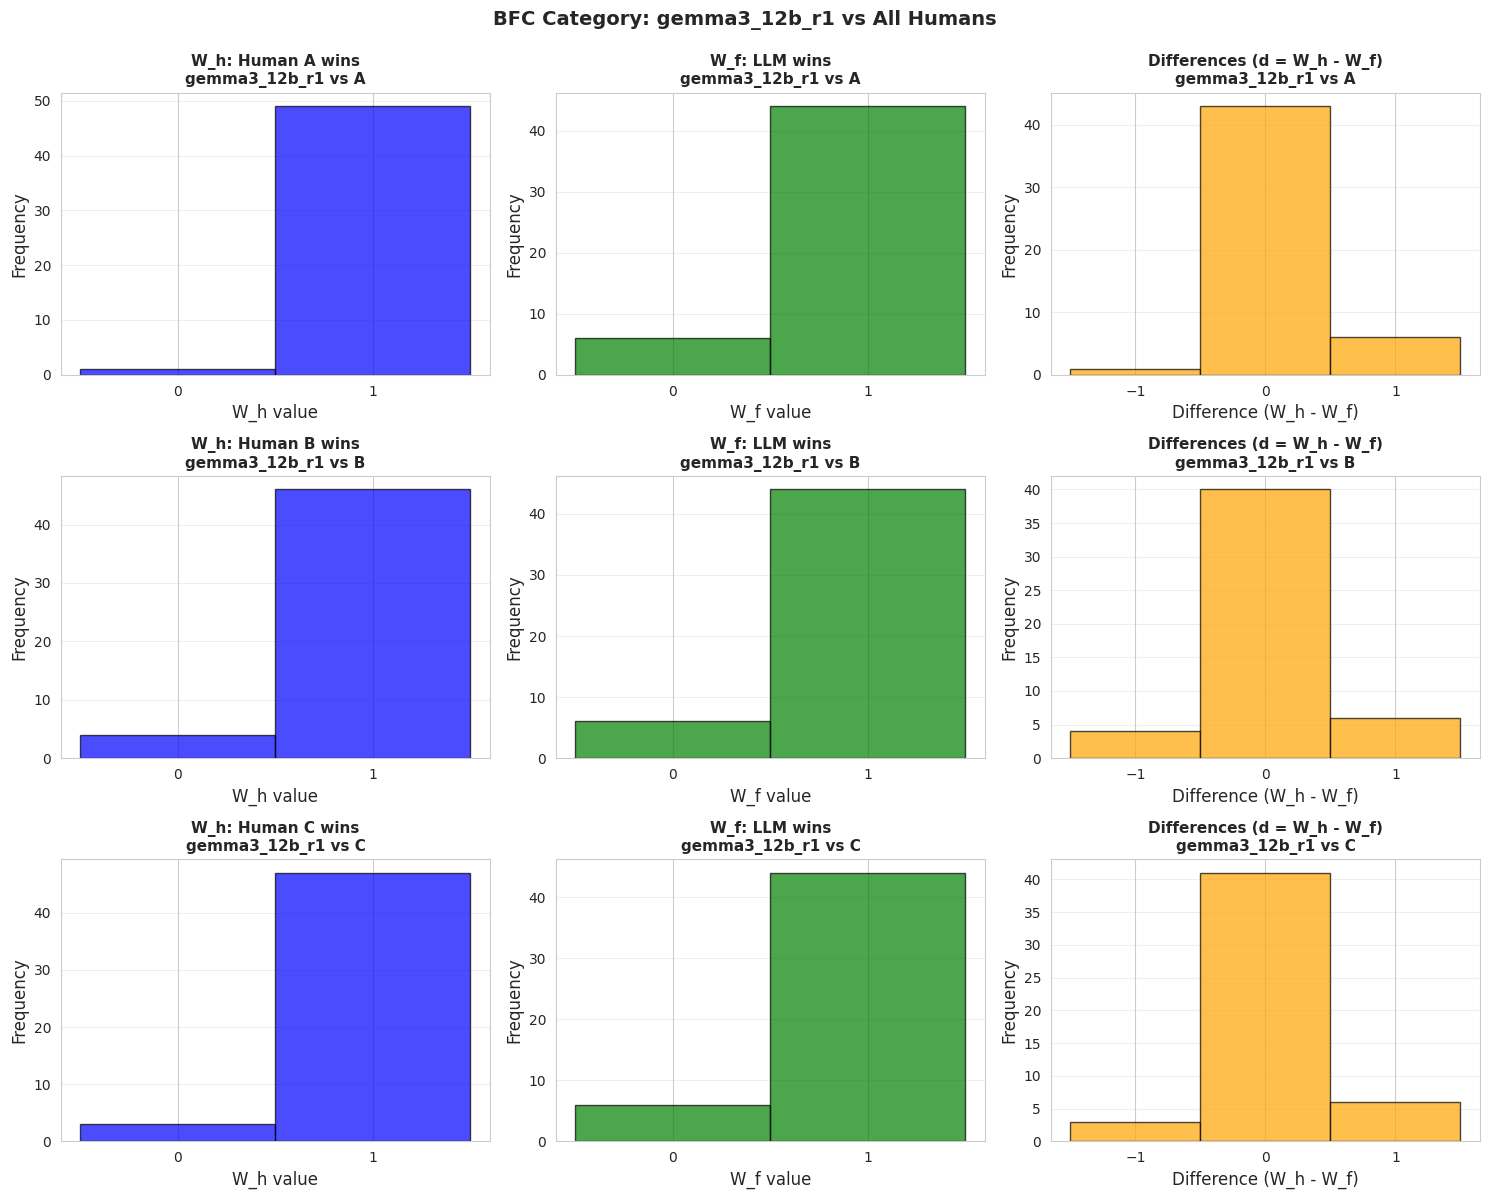


SUMMARY STATISTICS: gemma3_12b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human B:
  W_h (Human wins):  46/50 commits ( 92.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     4 commits (  8.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human C:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (

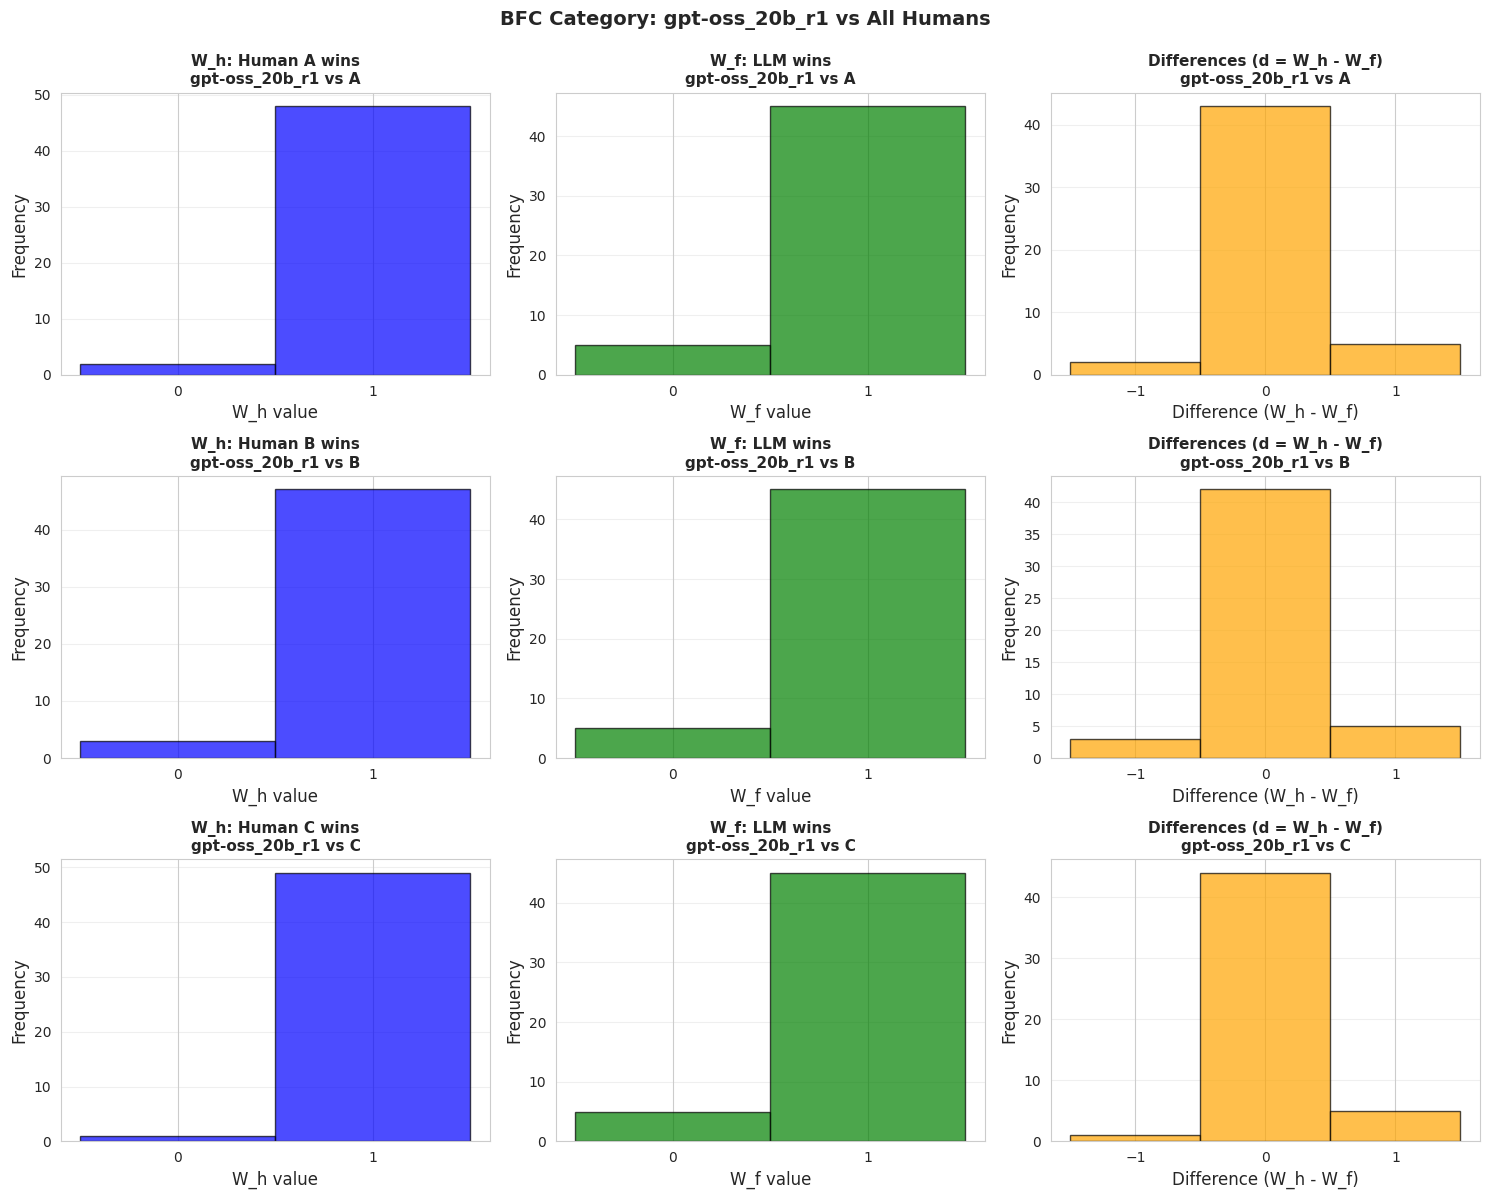


SUMMARY STATISTICS: gpt-oss_20b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   5 commits ( 10.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           42 commits ( 84.0%)
    d =  1 (Human better):   5 commits ( 10.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -44/50 commits (-88.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 

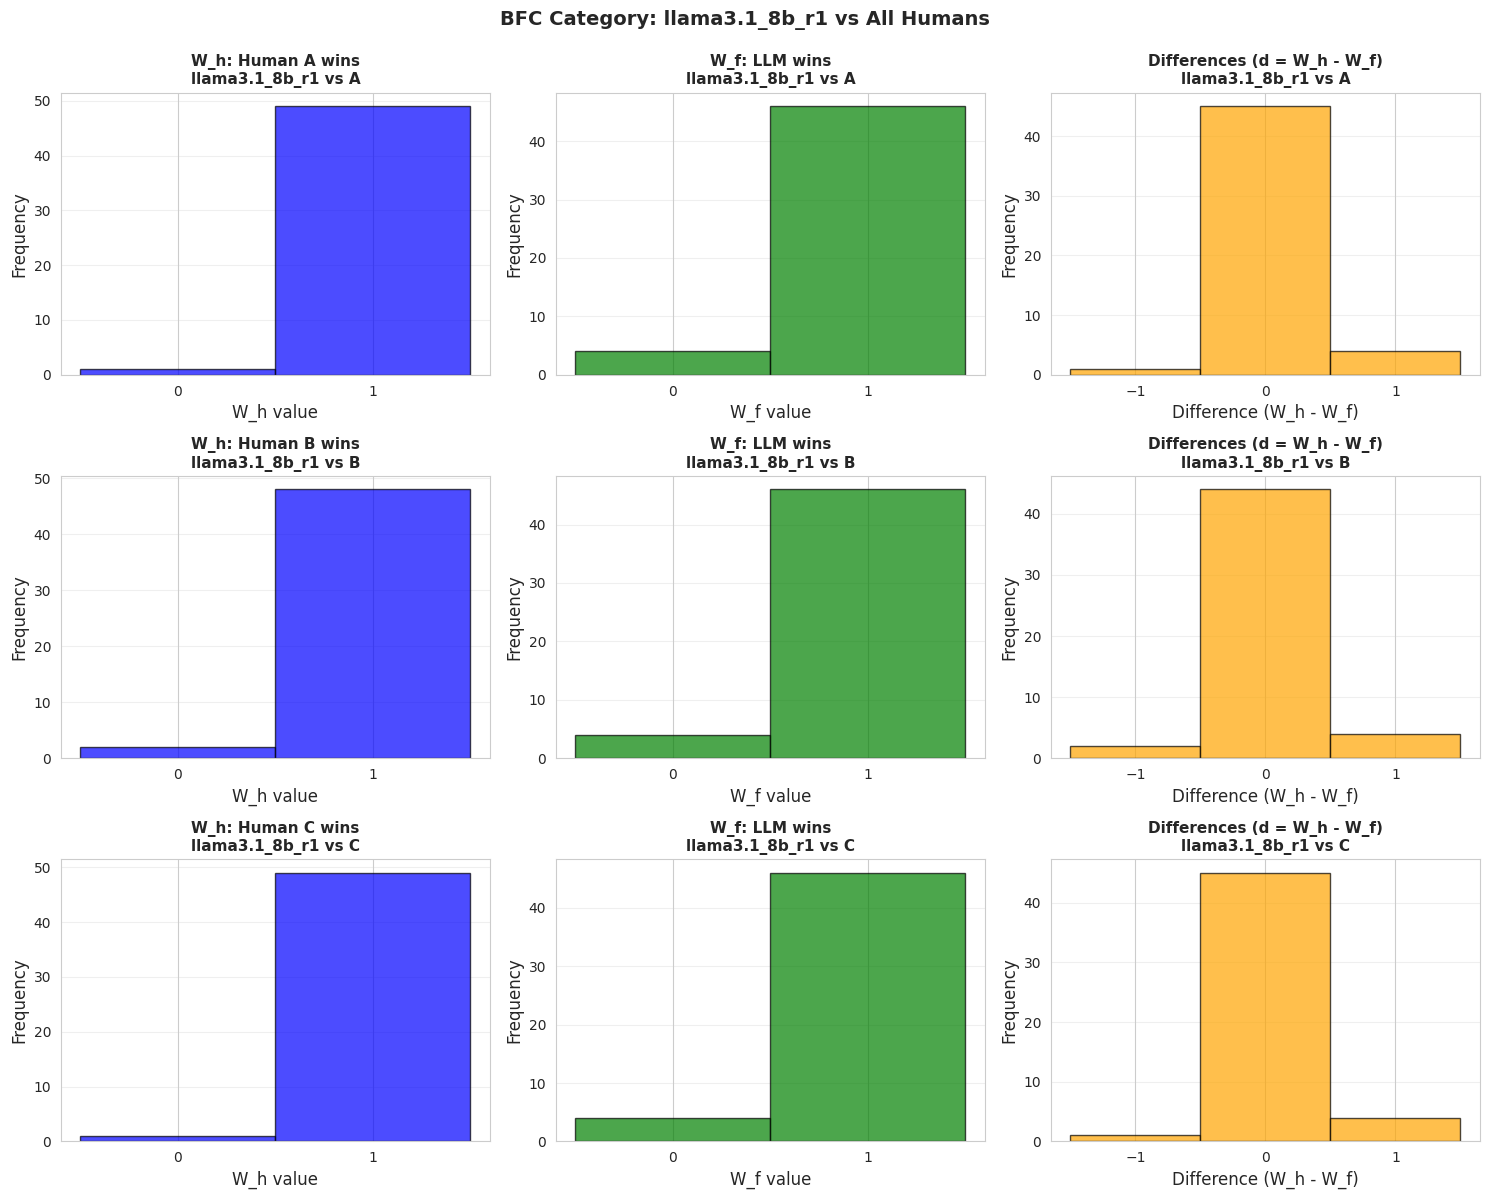


SUMMARY STATISTICS: llama3.1_8b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -45/50 commits (-90.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           45 commits ( 90.0%)
    d =  1 (Human better):   4 commits (  8.0%)

vs Human B:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -44/50 commits (-88.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           44 commits ( 88.0%)
    d =  1 (Human better):   4 commits (  8.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -45/50 commits (-90.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 

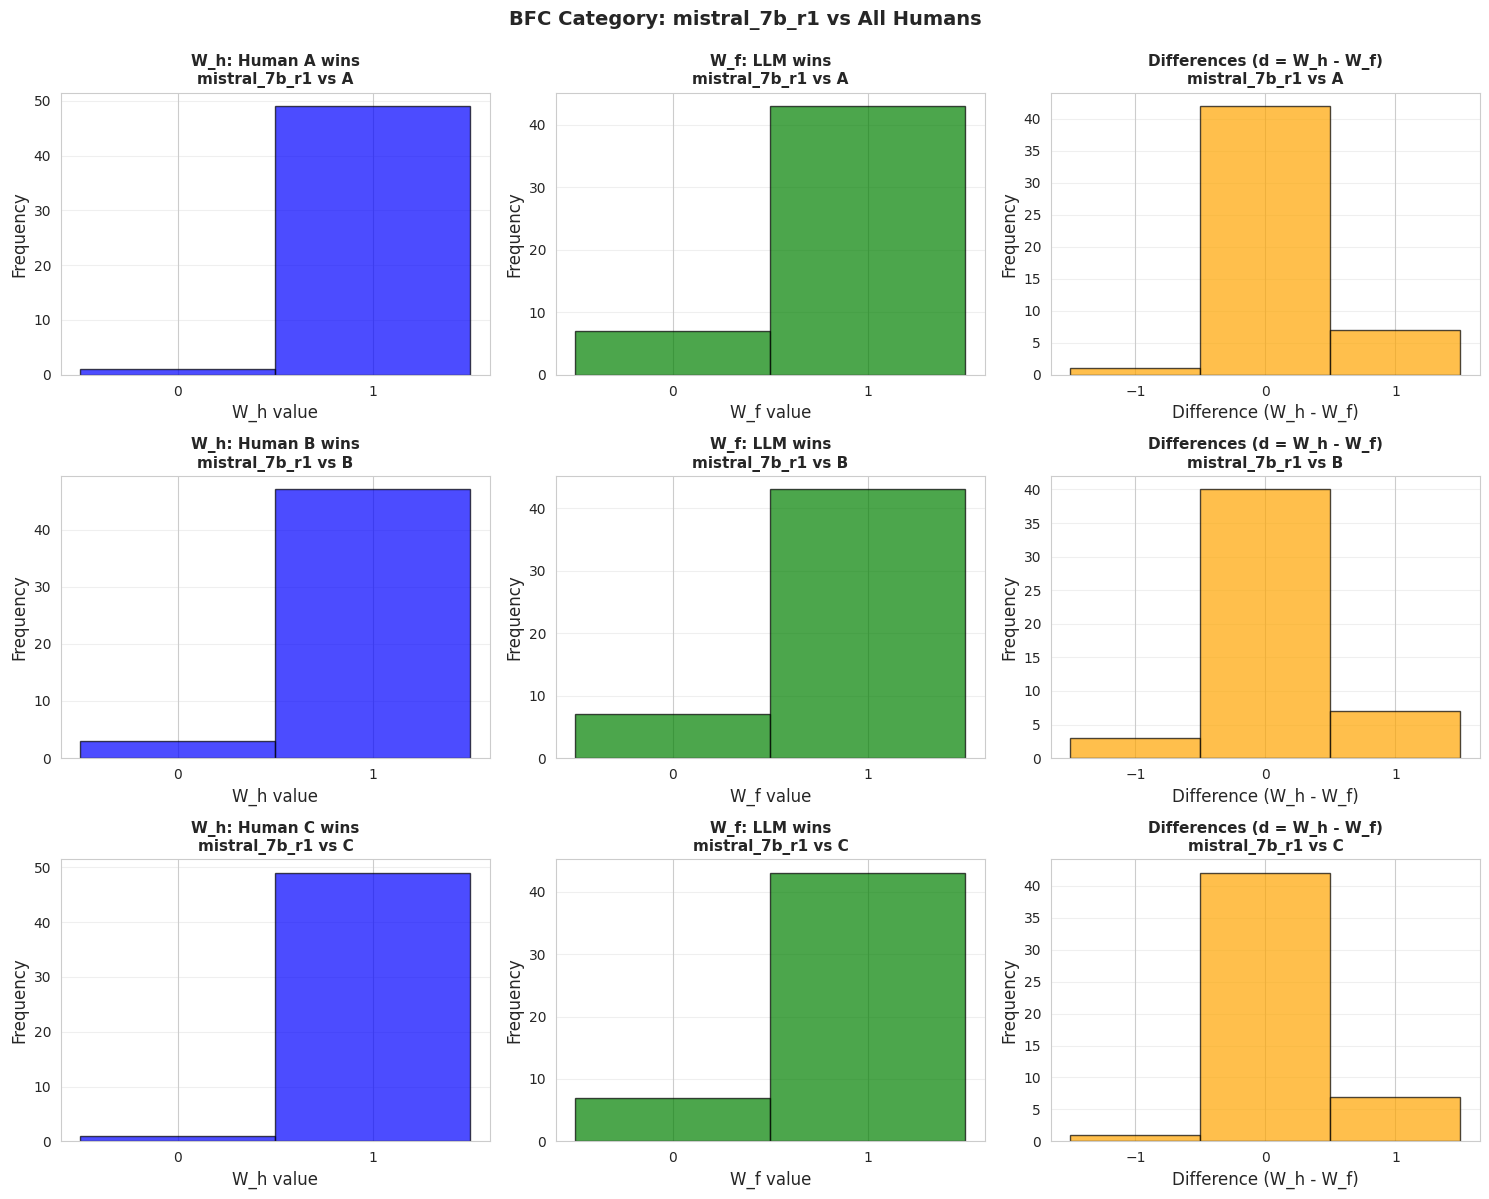


SUMMARY STATISTICS: mistral_7b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           42 commits ( 84.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (

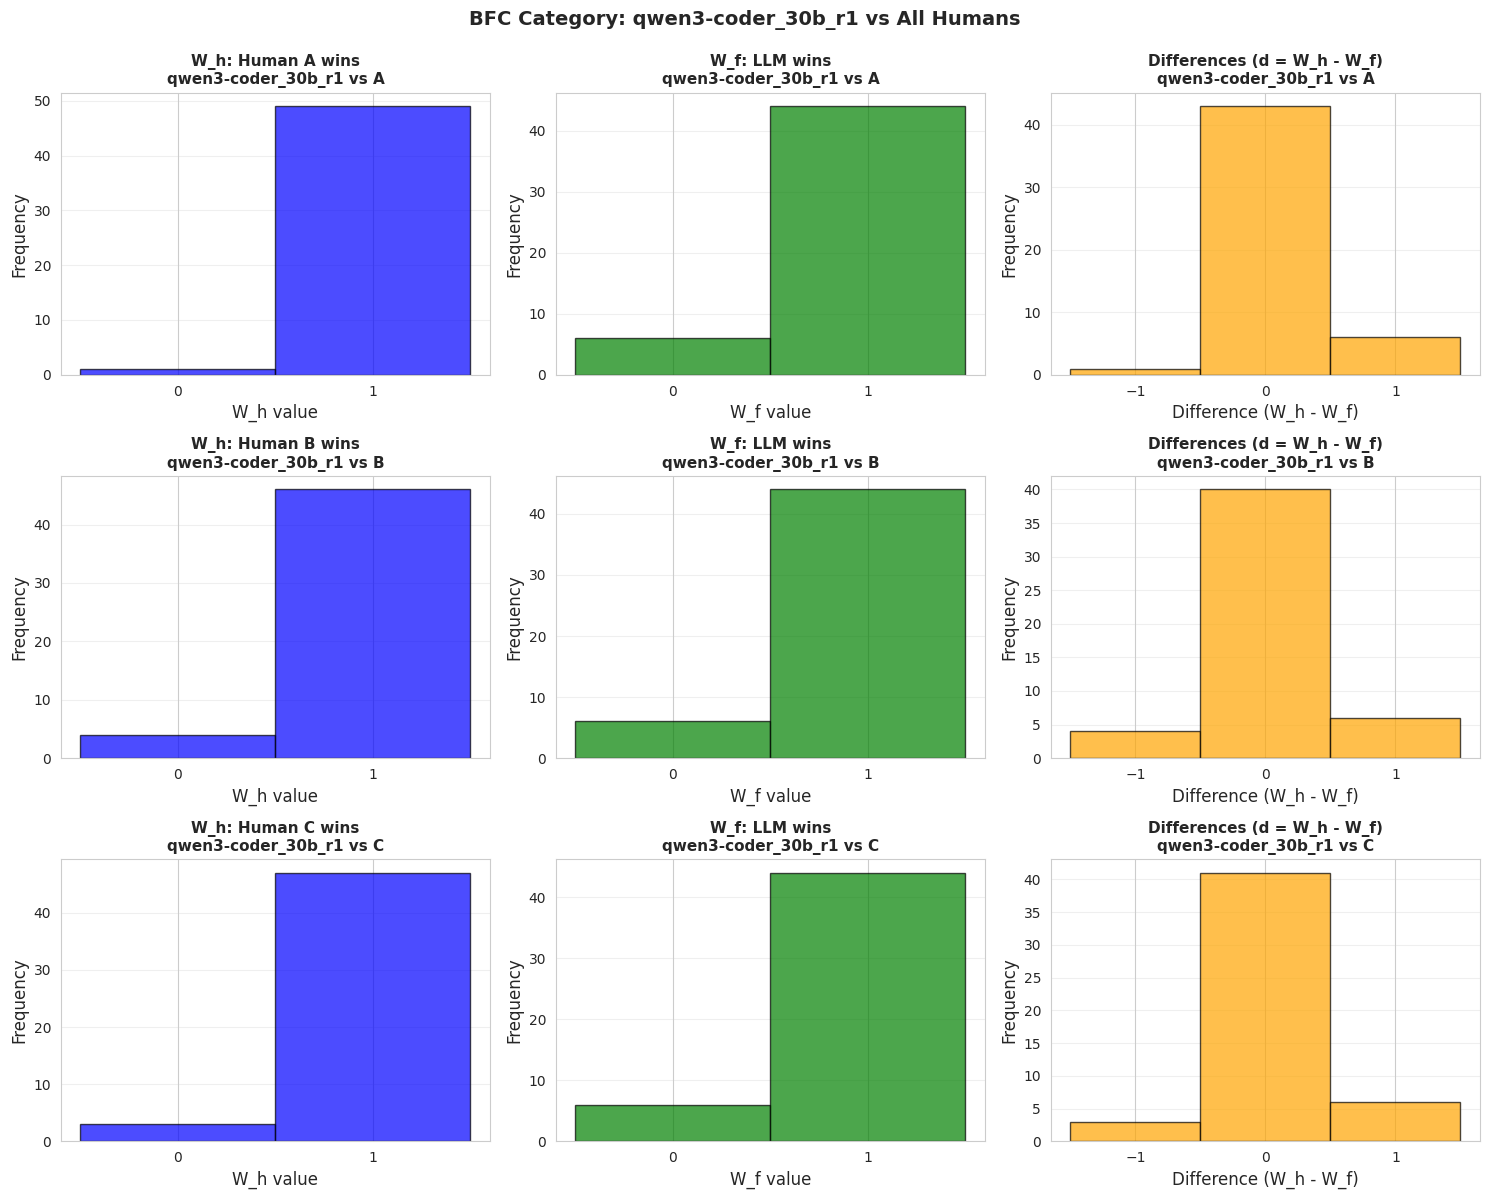


SUMMARY STATISTICS: qwen3-coder_30b_r1 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human B:
  W_h (Human wins):  46/50 commits ( 92.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     4 commits (  8.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human C:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =

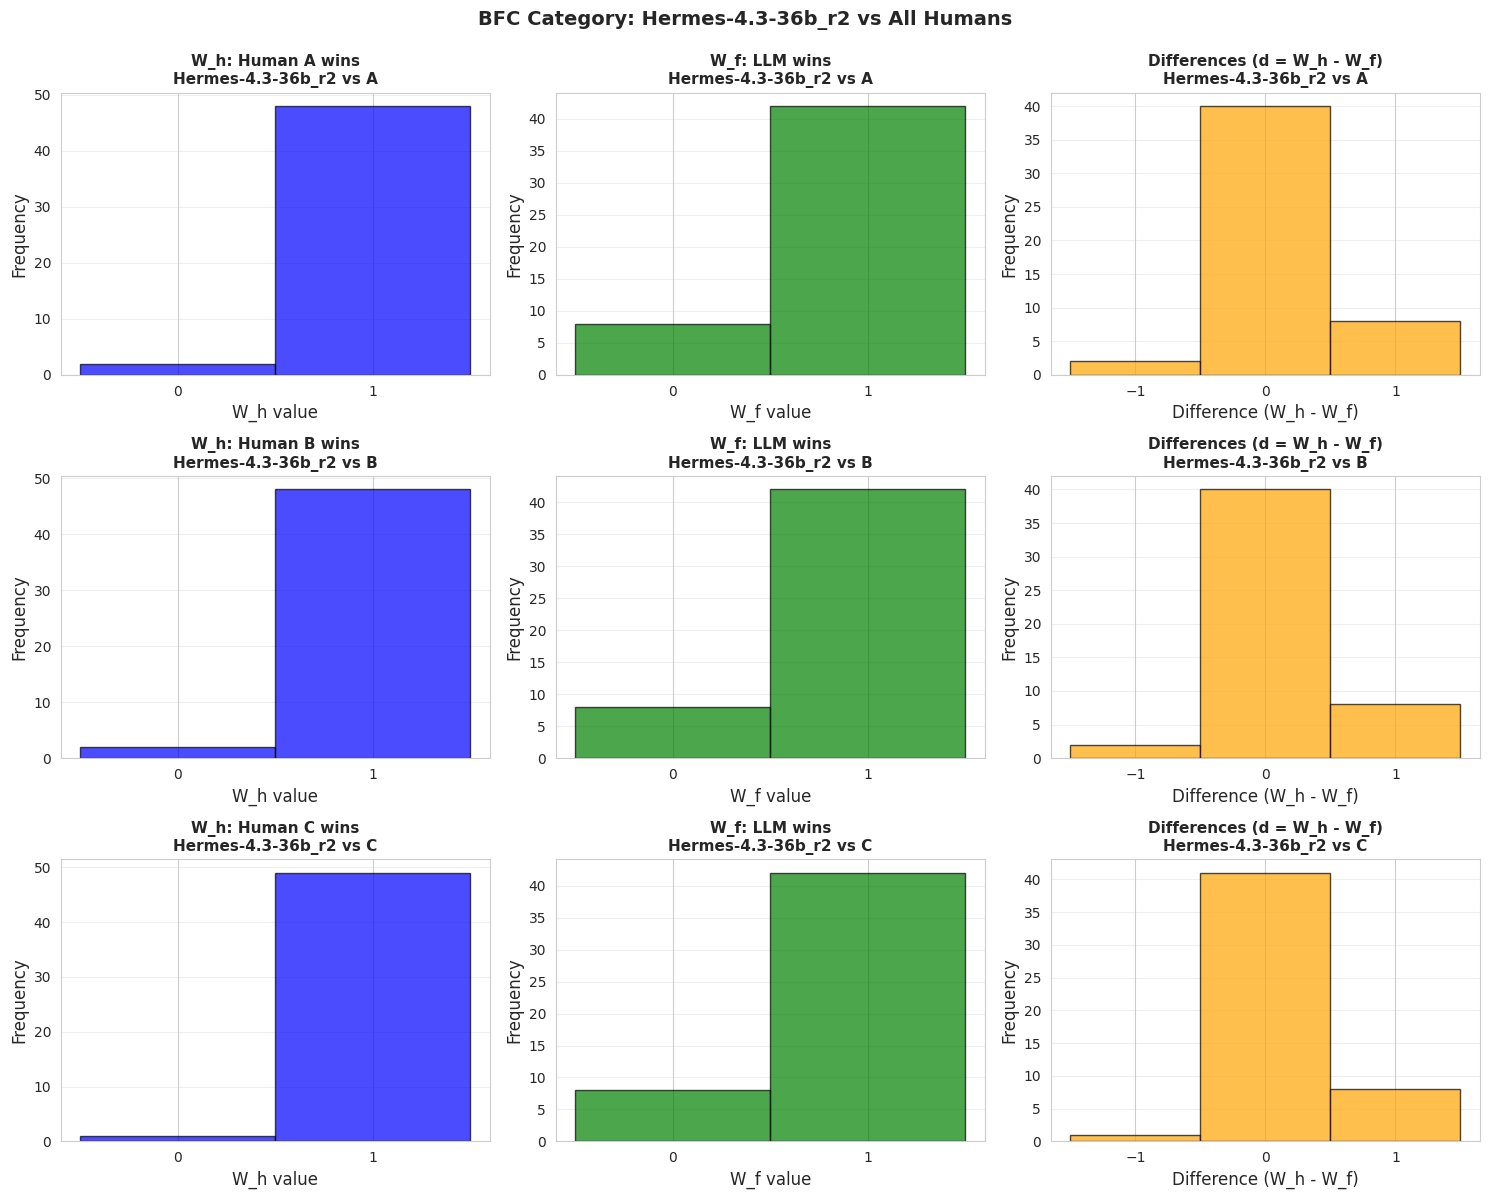


SUMMARY STATISTICS: Hermes-4.3-36b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   8 commits ( 16.0%)

vs Human B:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   8 commits ( 16.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d = 

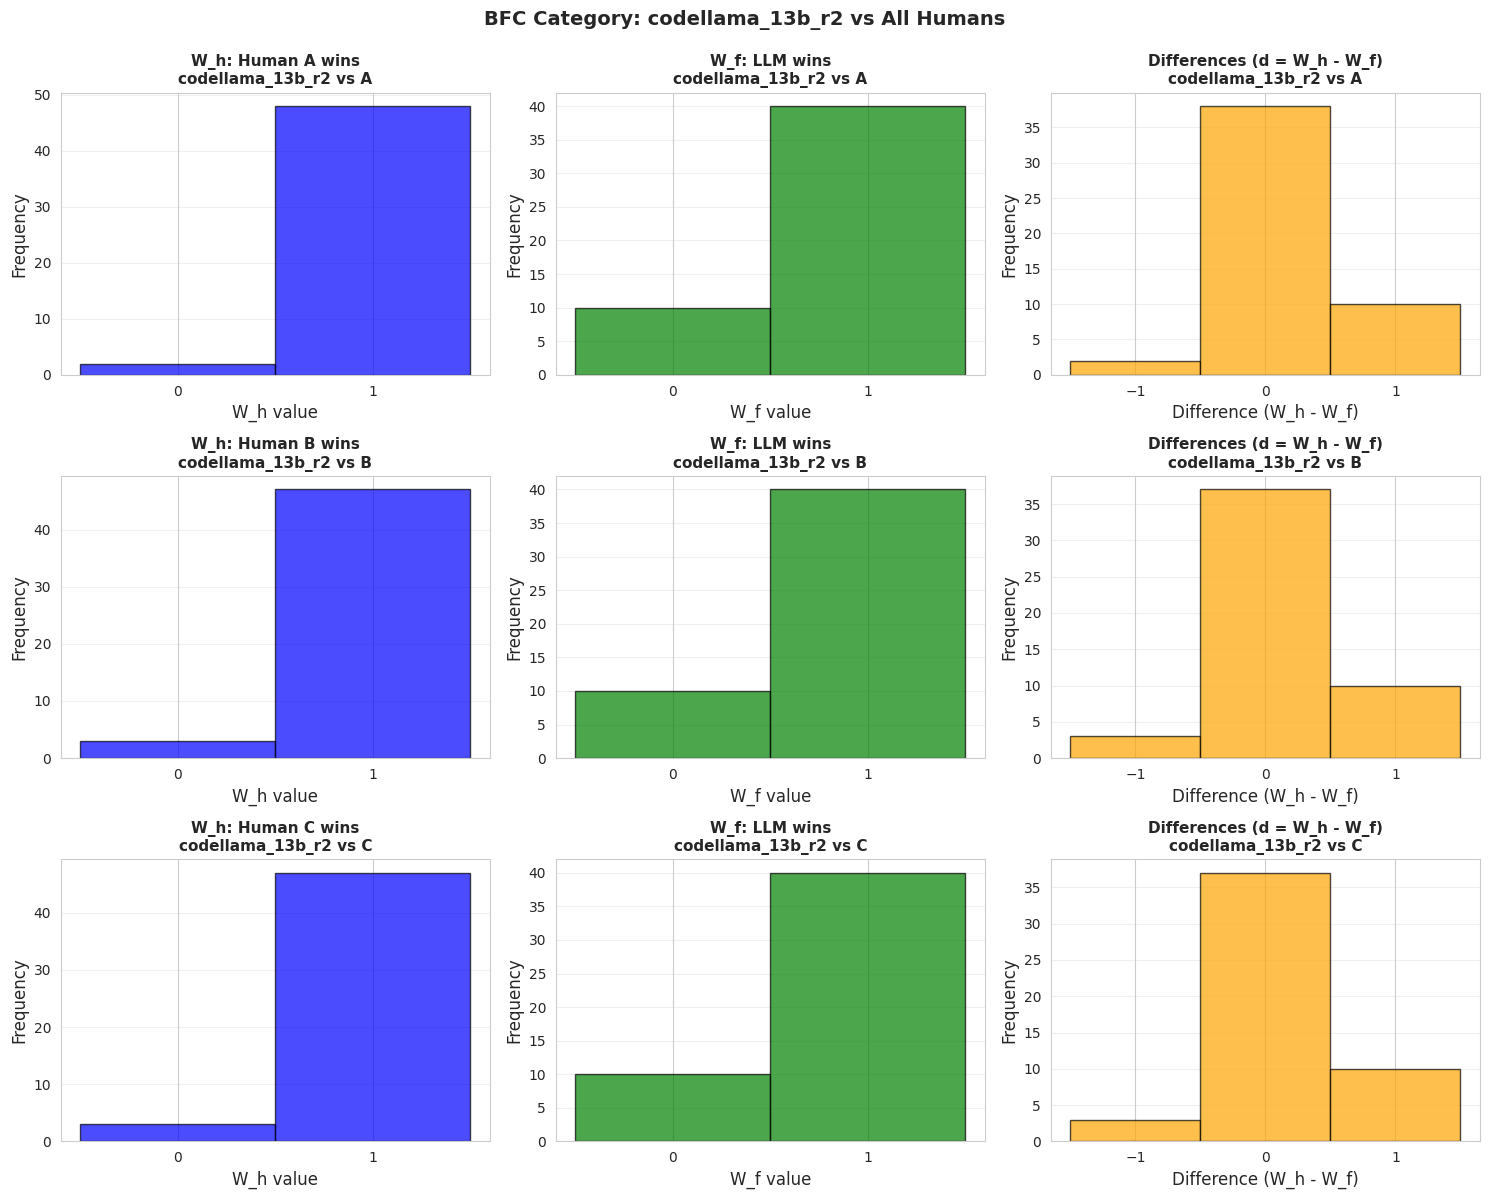


SUMMARY STATISTICS: codellama_13b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    40/50 commits ( 80.0%)
  Ties:             -38/50 commits (-76.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           38 commits ( 76.0%)
    d =  1 (Human better):  10 commits ( 20.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    40/50 commits ( 80.0%)
  Ties:             -37/50 commits (-74.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           37 commits ( 74.0%)
    d =  1 (Human better):  10 commits ( 20.0%)

vs Human C:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    40/50 commits ( 80.0%)
  Ties:             -37/50 commits (-74.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  

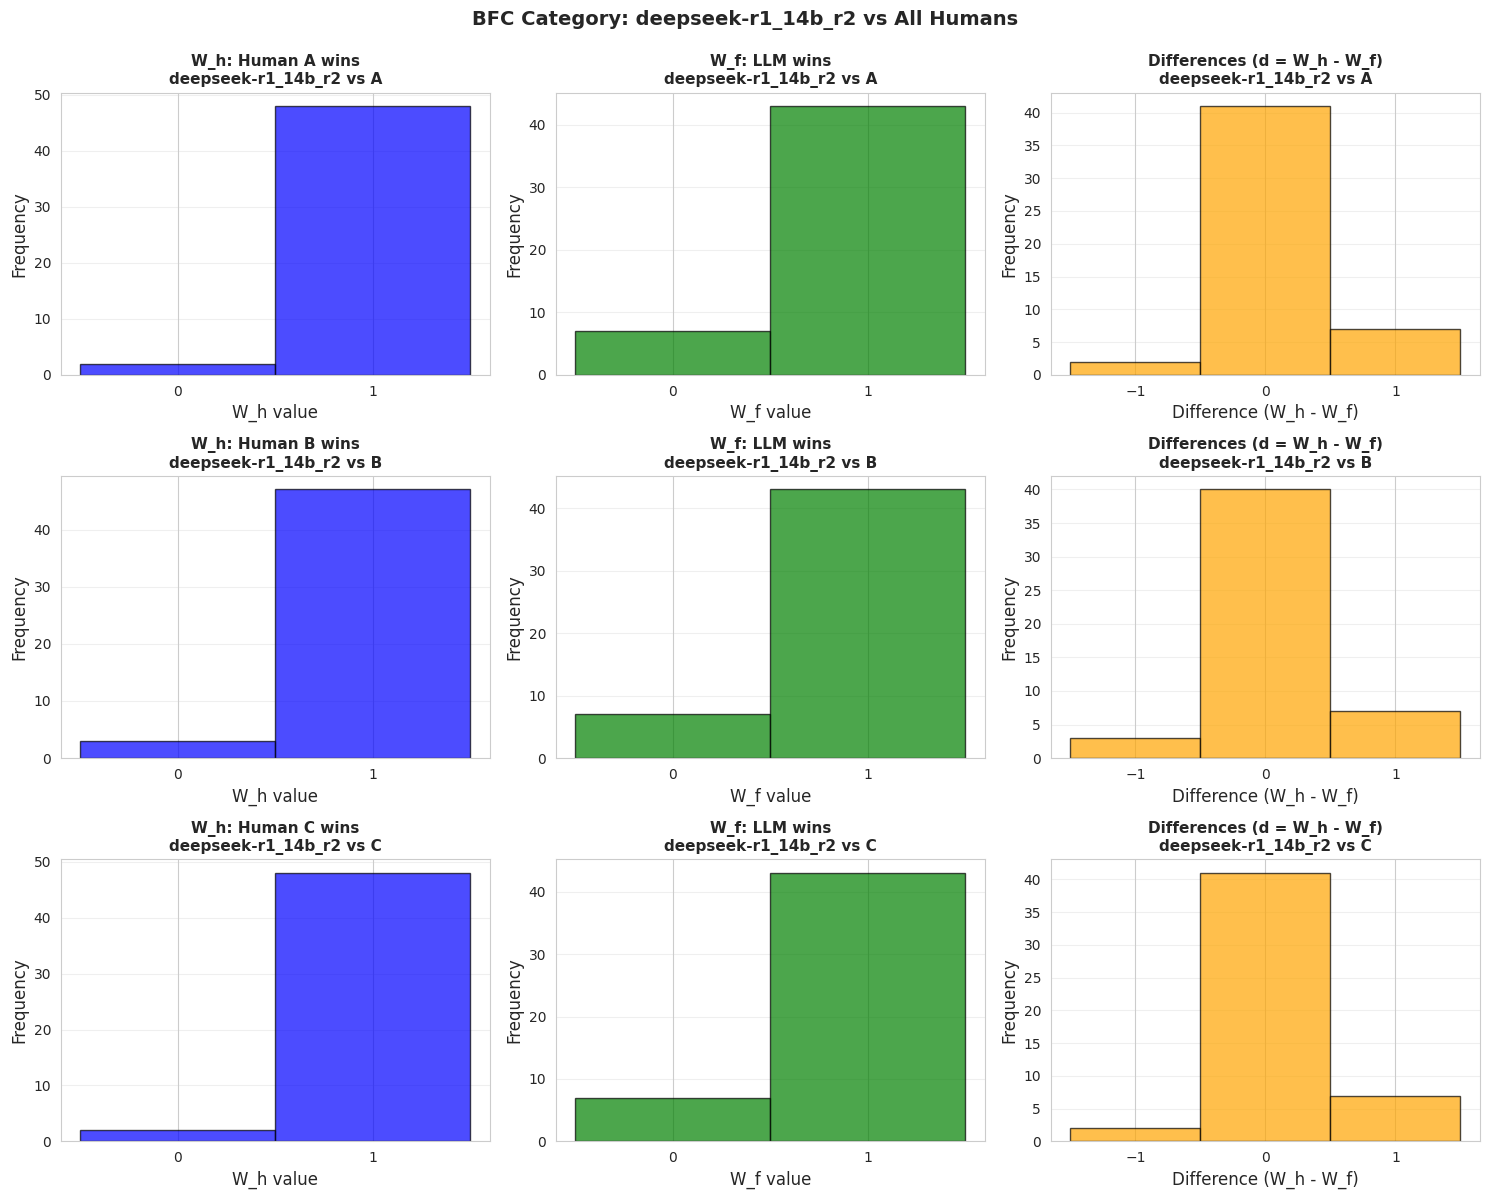


SUMMARY STATISTICS: deepseek-r1_14b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           41 commits ( 82.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human C:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =

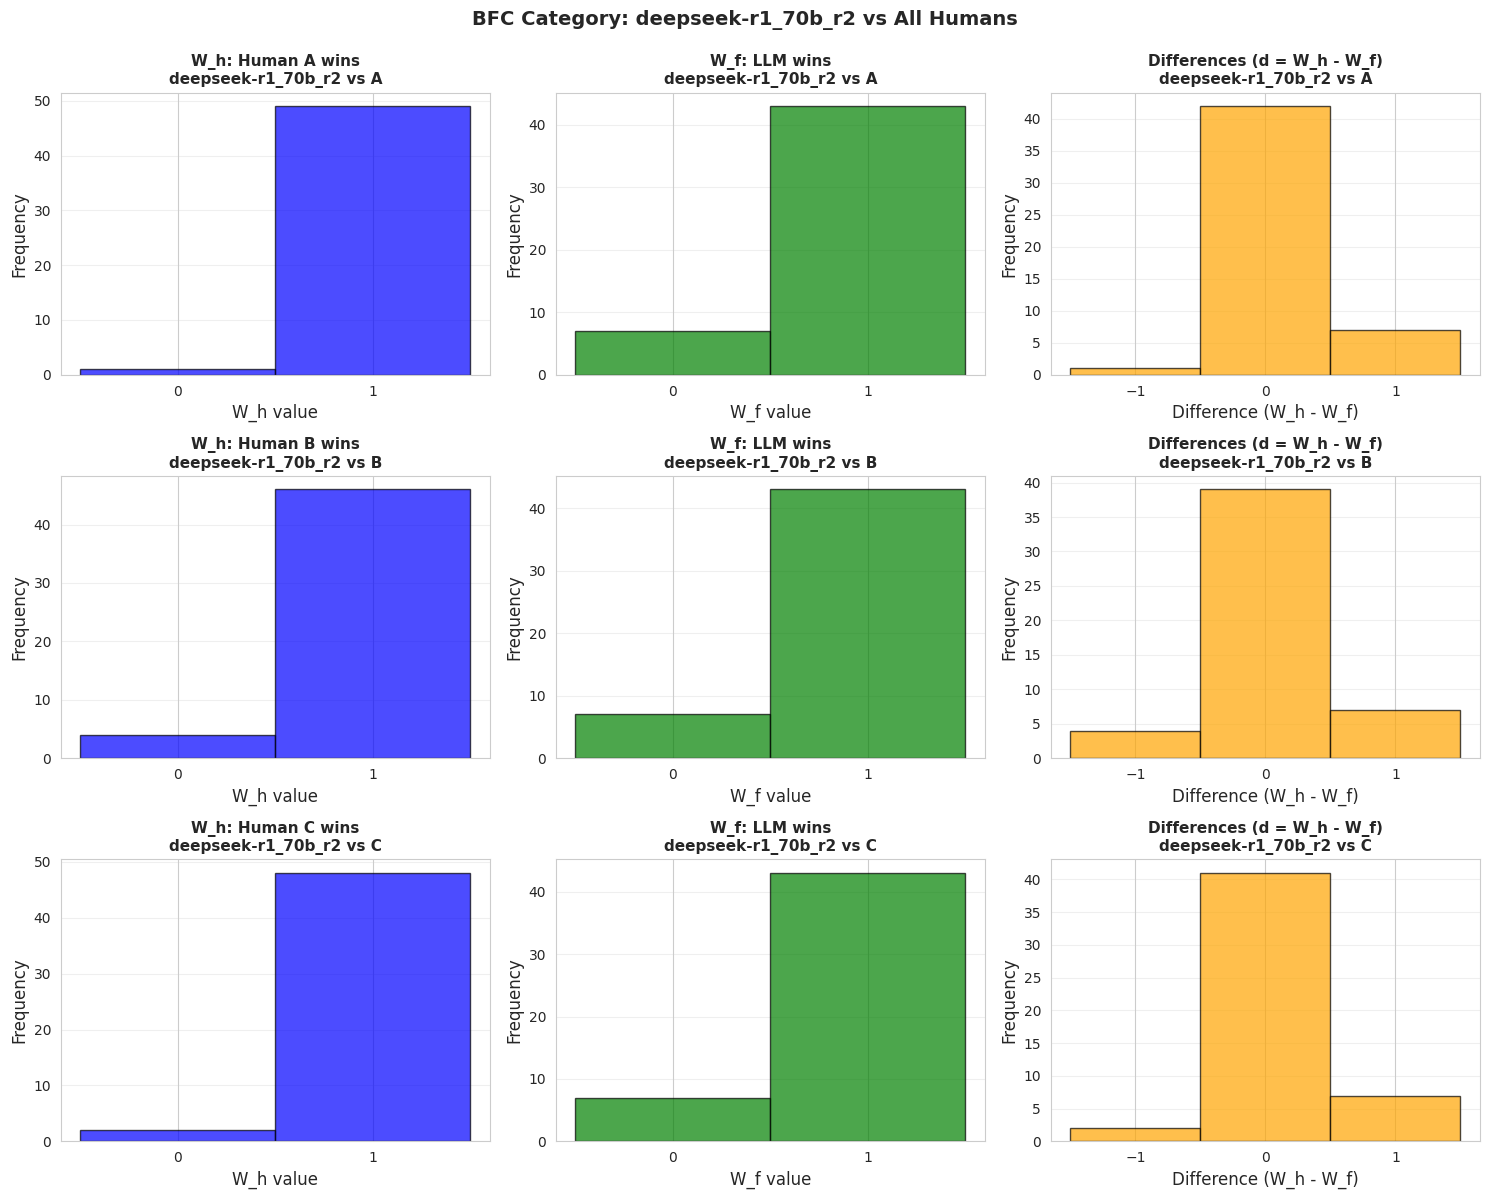


SUMMARY STATISTICS: deepseek-r1_70b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           42 commits ( 84.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human B:
  W_h (Human wins):  46/50 commits ( 92.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -39/50 commits (-78.0%)
  Difference distribution:
    d = -1 (LLM better):     4 commits (  8.0%)
    d =  0 (Tie):           39 commits ( 78.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human C:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =

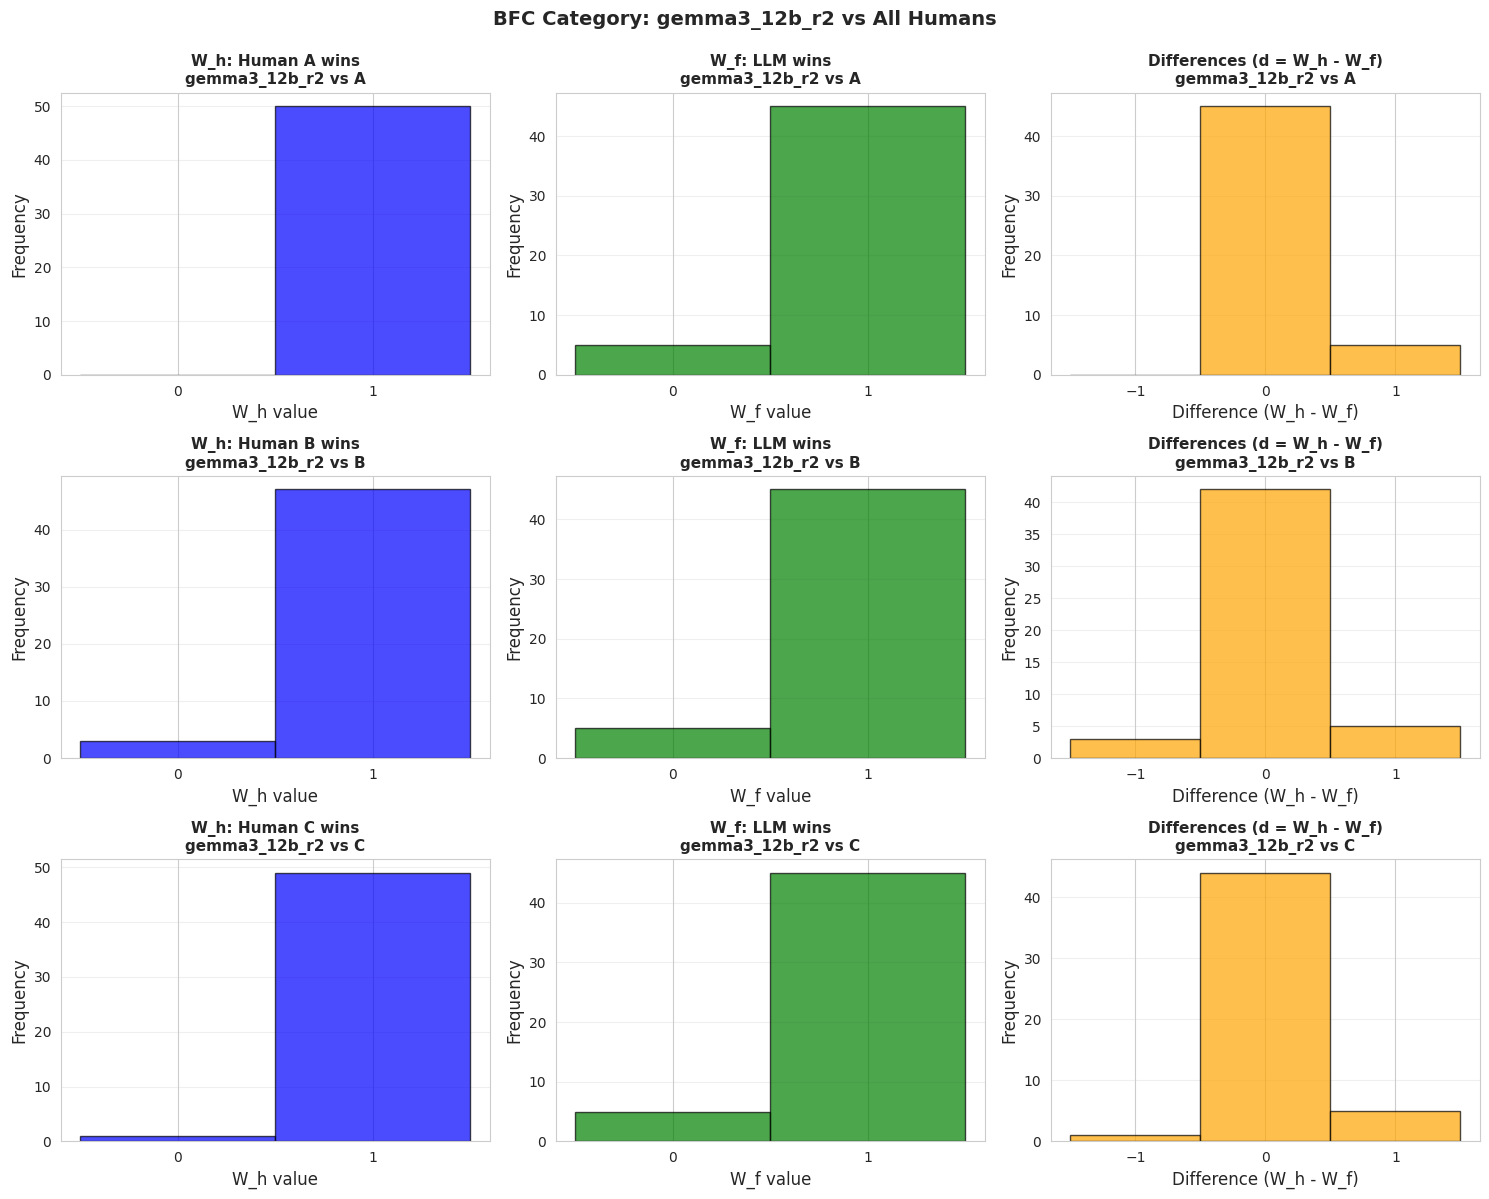


SUMMARY STATISTICS: gemma3_12b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  50/50 commits (100.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -45/50 commits (-90.0%)
  Difference distribution:
    d = -1 (LLM better):     0 commits (  0.0%)
    d =  0 (Tie):           45 commits ( 90.0%)
    d =  1 (Human better):   5 commits ( 10.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           42 commits ( 84.0%)
    d =  1 (Human better):   5 commits ( 10.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    45/50 commits ( 90.0%)
  Ties:             -44/50 commits (-88.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (

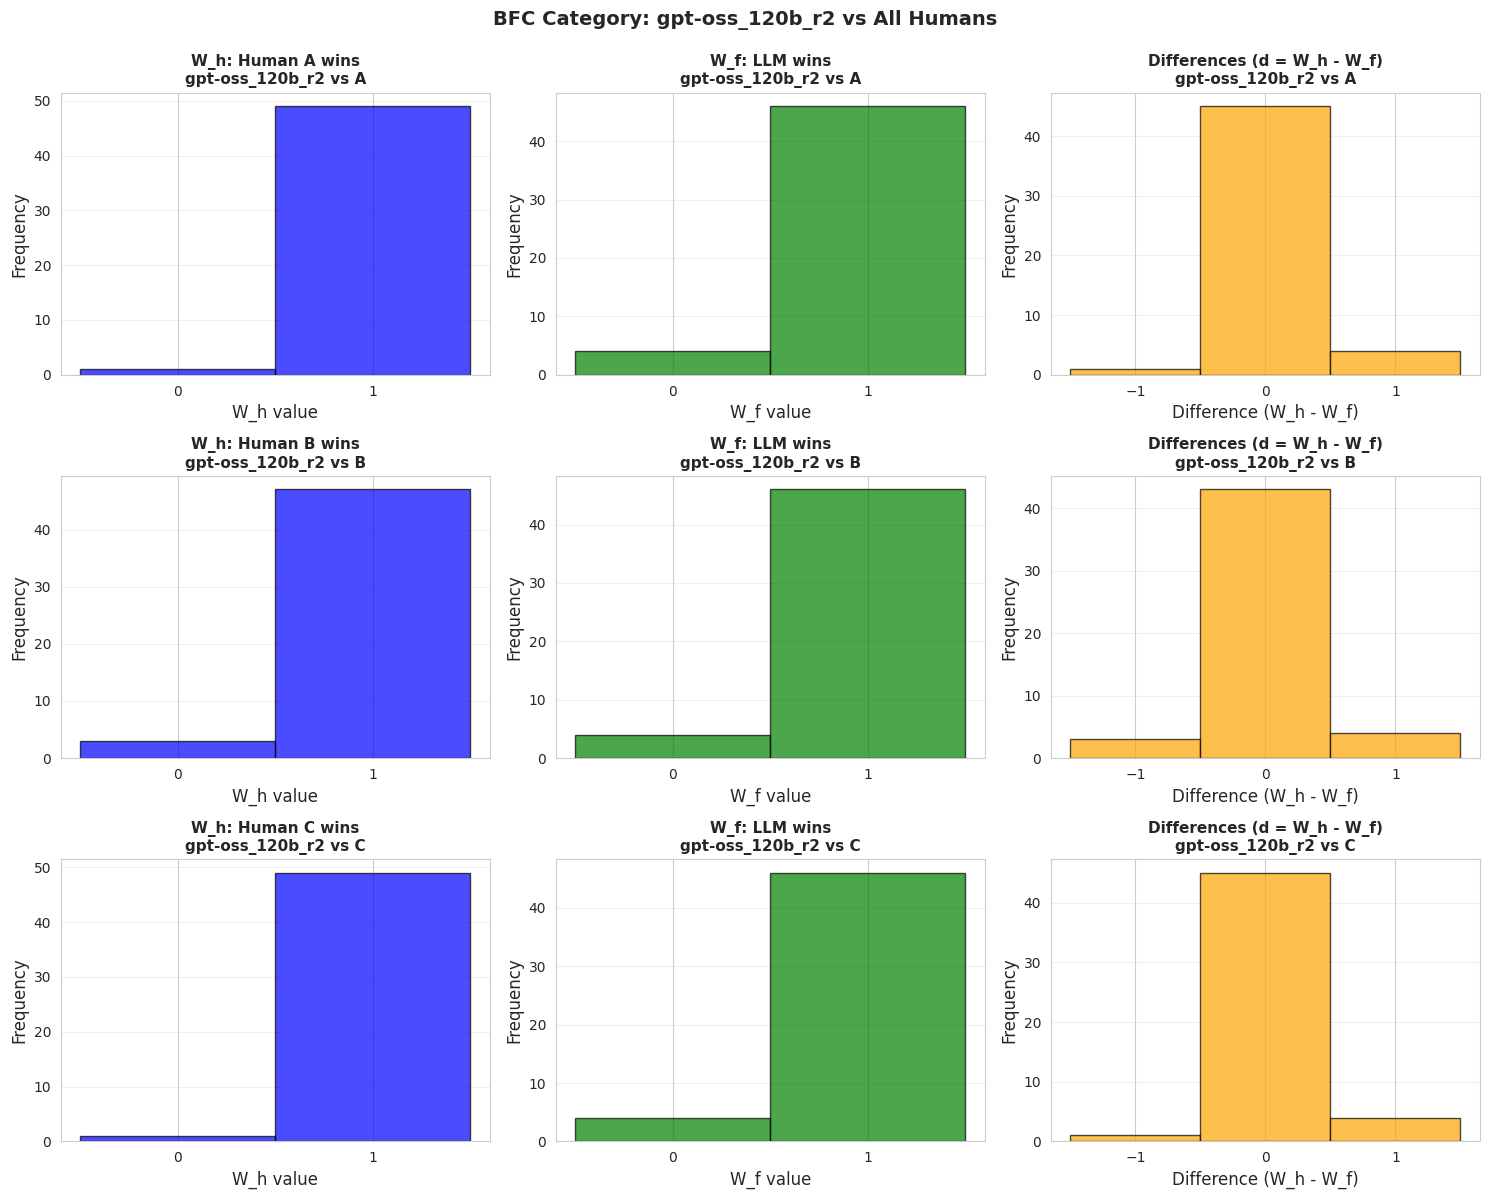


SUMMARY STATISTICS: gpt-oss_120b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -45/50 commits (-90.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           45 commits ( 90.0%)
    d =  1 (Human better):   4 commits (  8.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   4 commits (  8.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    46/50 commits ( 92.0%)
  Ties:             -45/50 commits (-90.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0

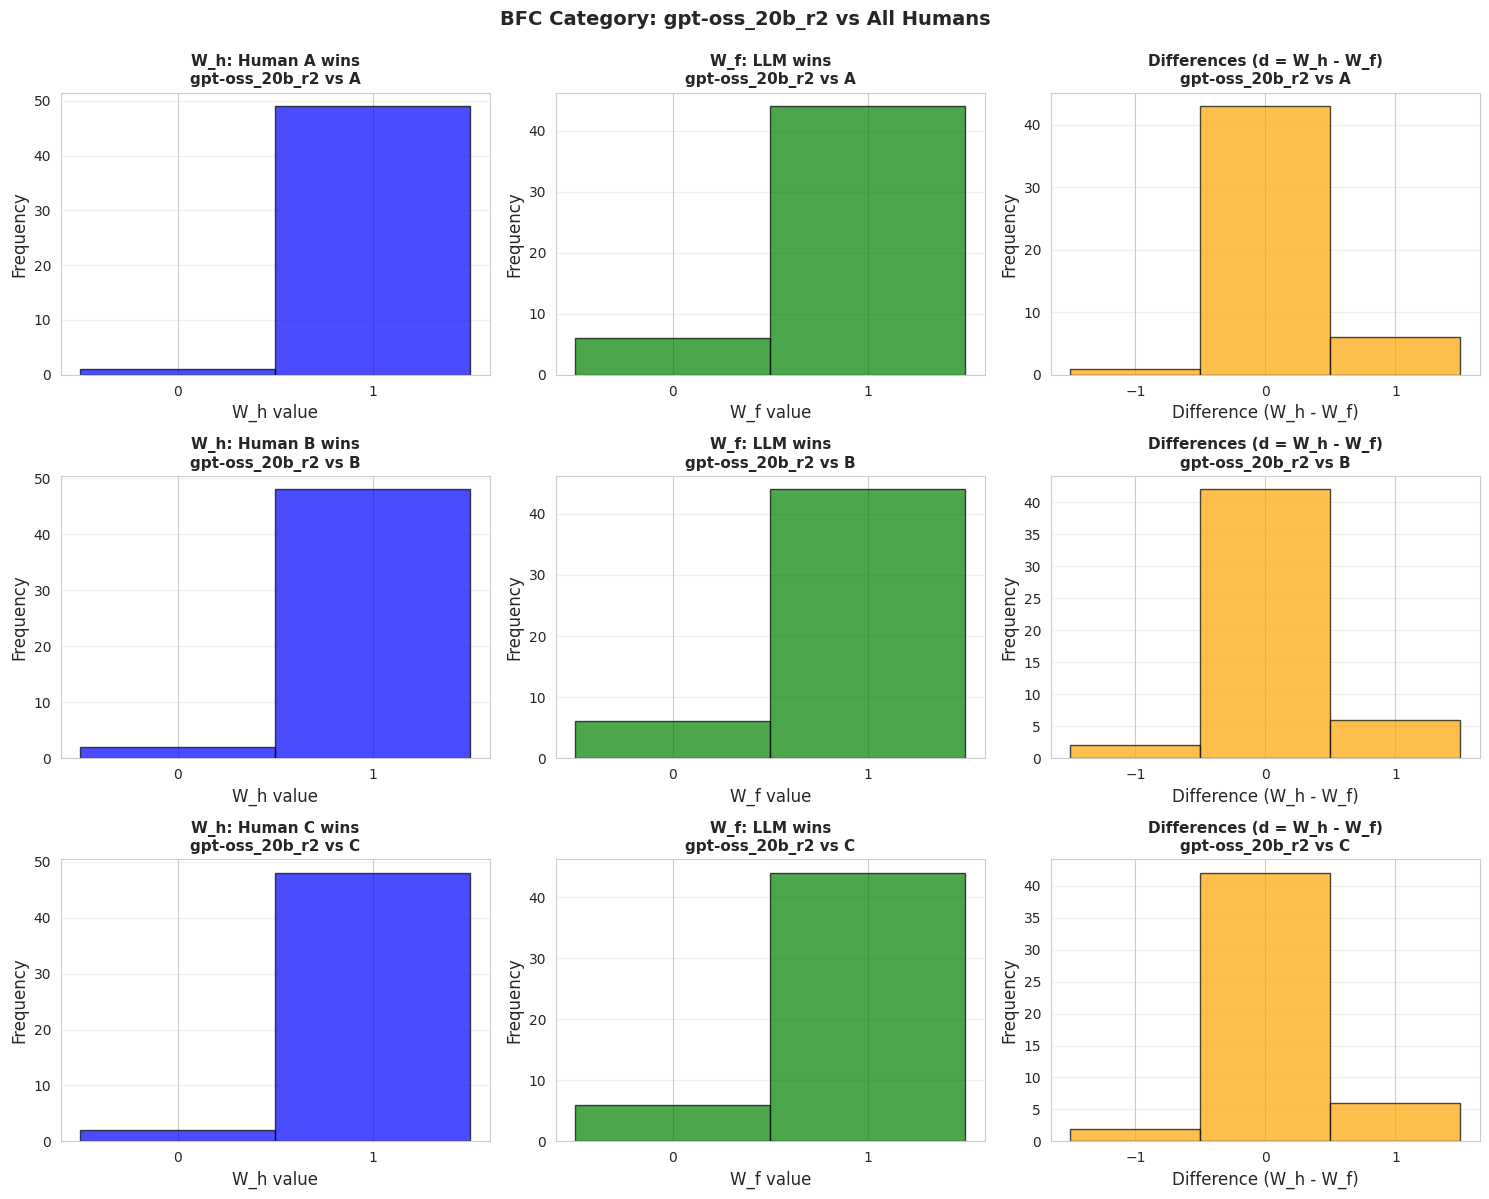


SUMMARY STATISTICS: gpt-oss_20b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human B:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           42 commits ( 84.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human C:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 

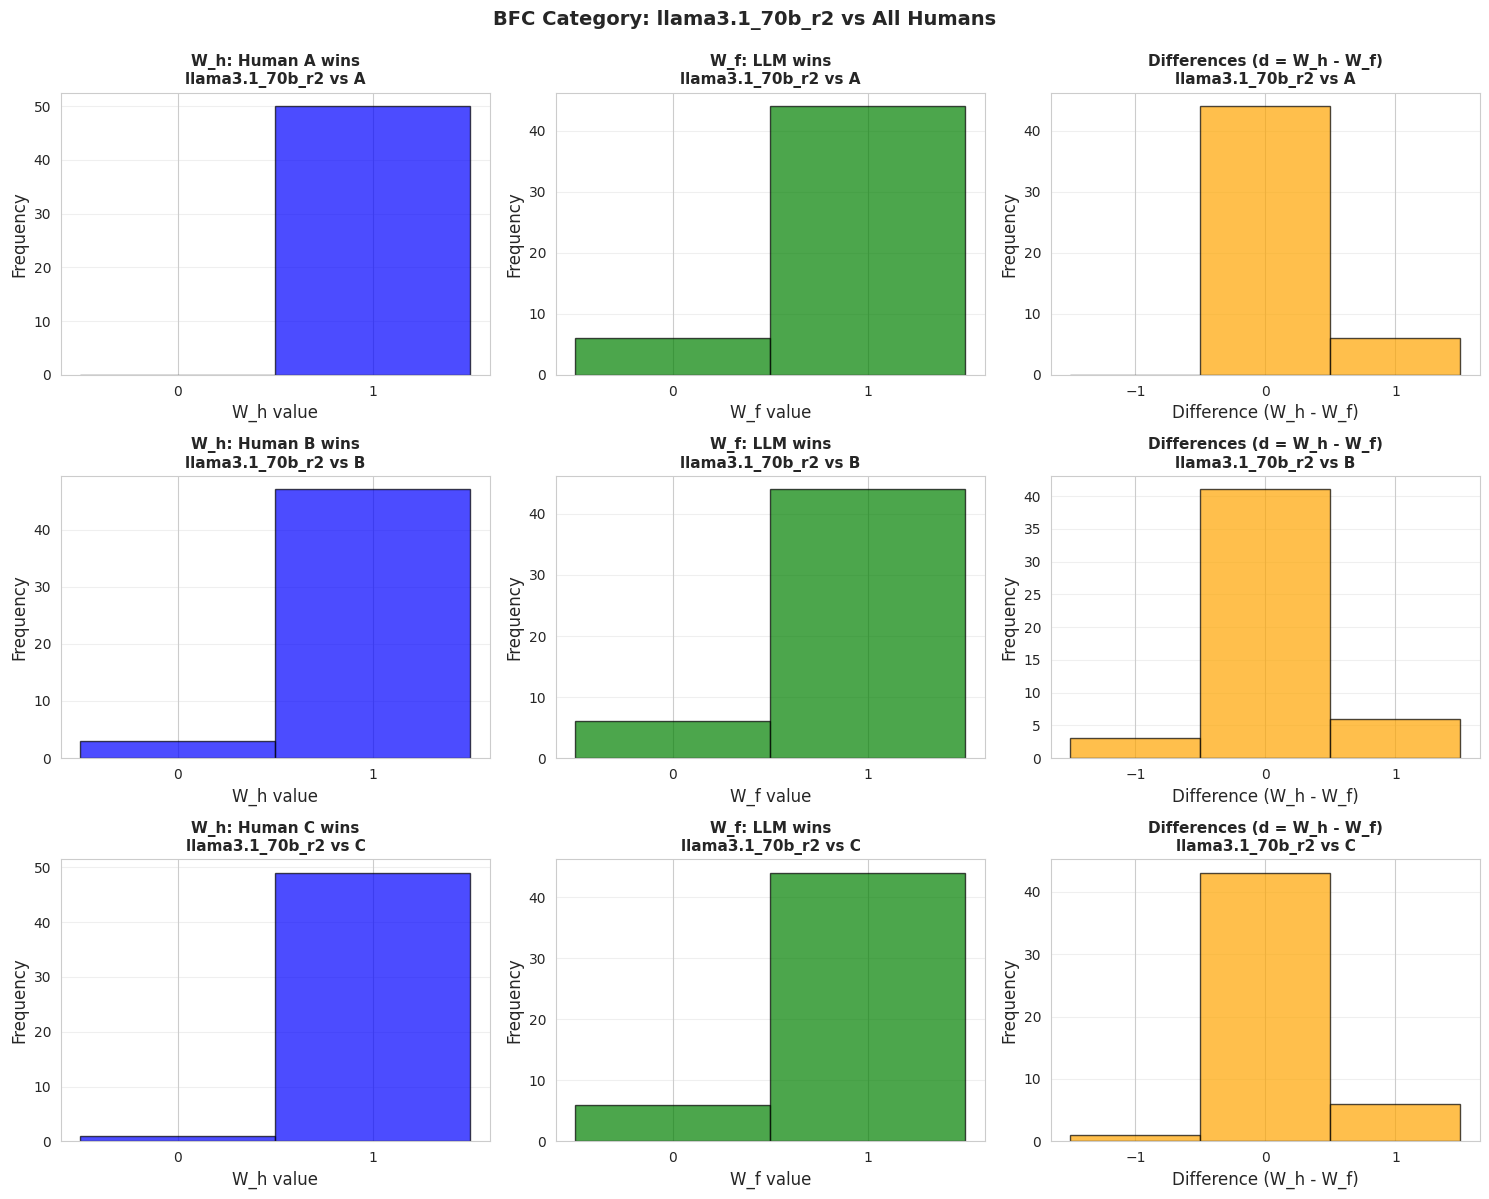


SUMMARY STATISTICS: llama3.1_70b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  50/50 commits (100.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -44/50 commits (-88.0%)
  Difference distribution:
    d = -1 (LLM better):     0 commits (  0.0%)
    d =  0 (Tie):           44 commits ( 88.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           41 commits ( 82.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0

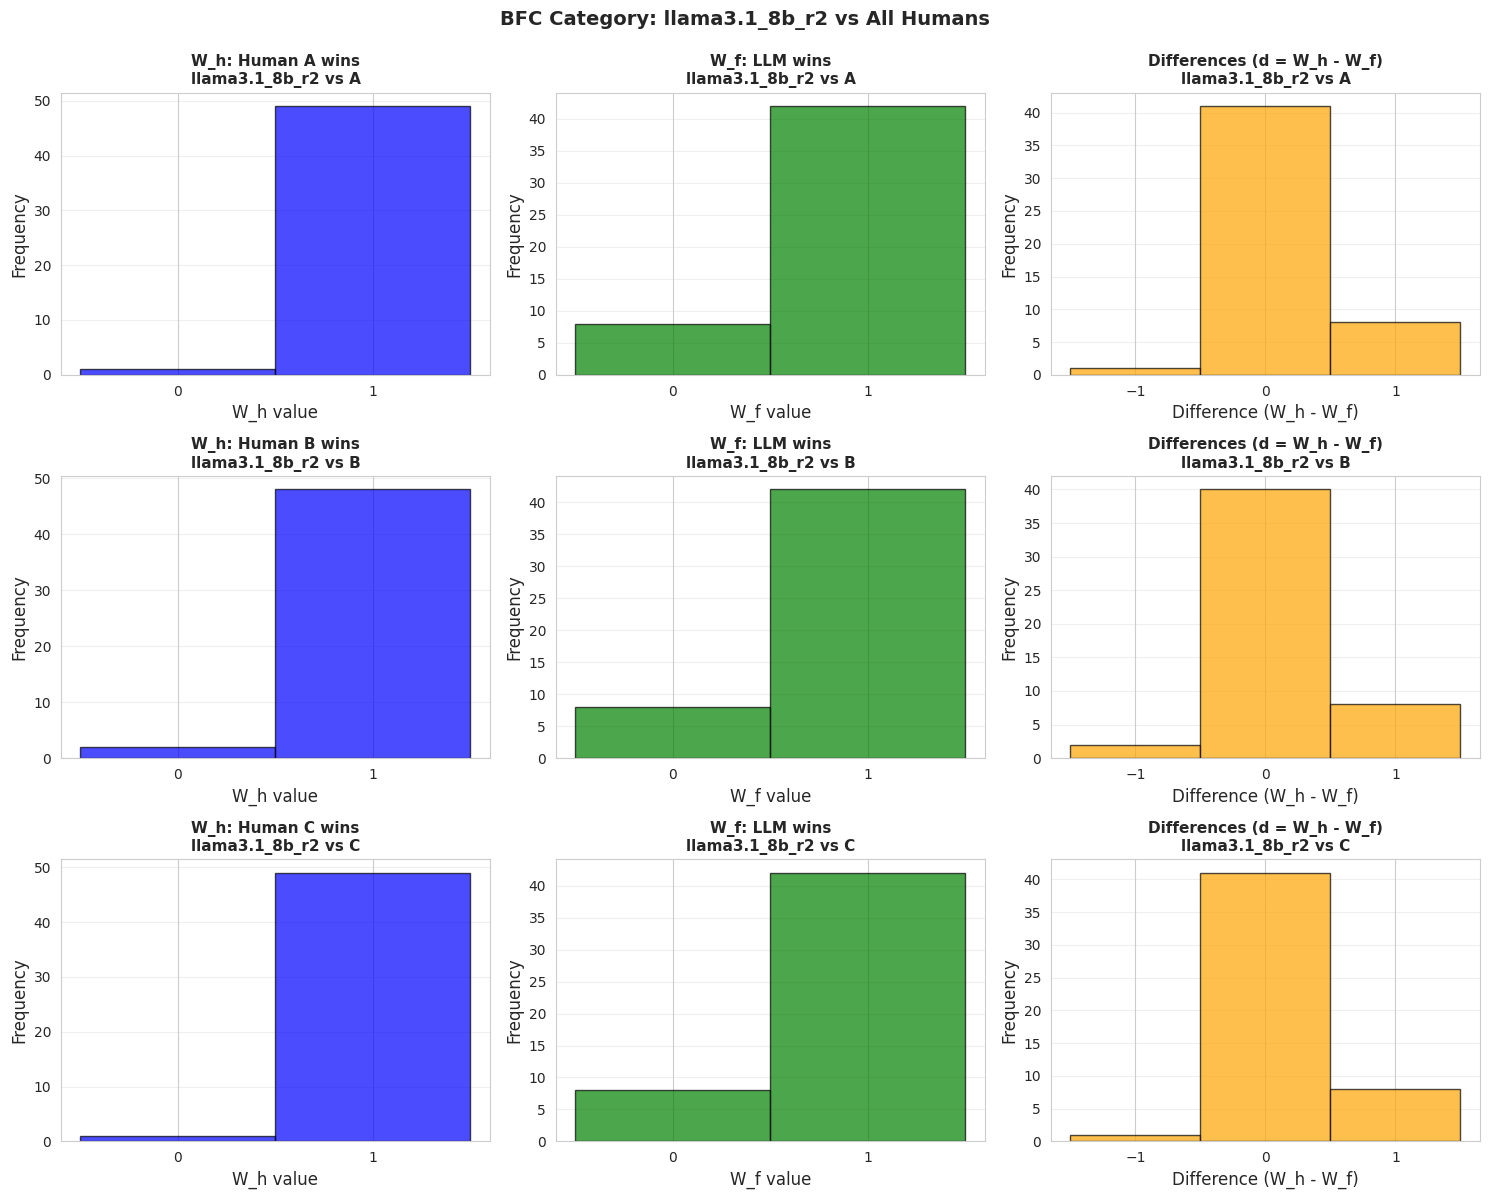


SUMMARY STATISTICS: llama3.1_8b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (Tie):           41 commits ( 82.0%)
    d =  1 (Human better):   8 commits ( 16.0%)

vs Human B:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   8 commits ( 16.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    42/50 commits ( 84.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 

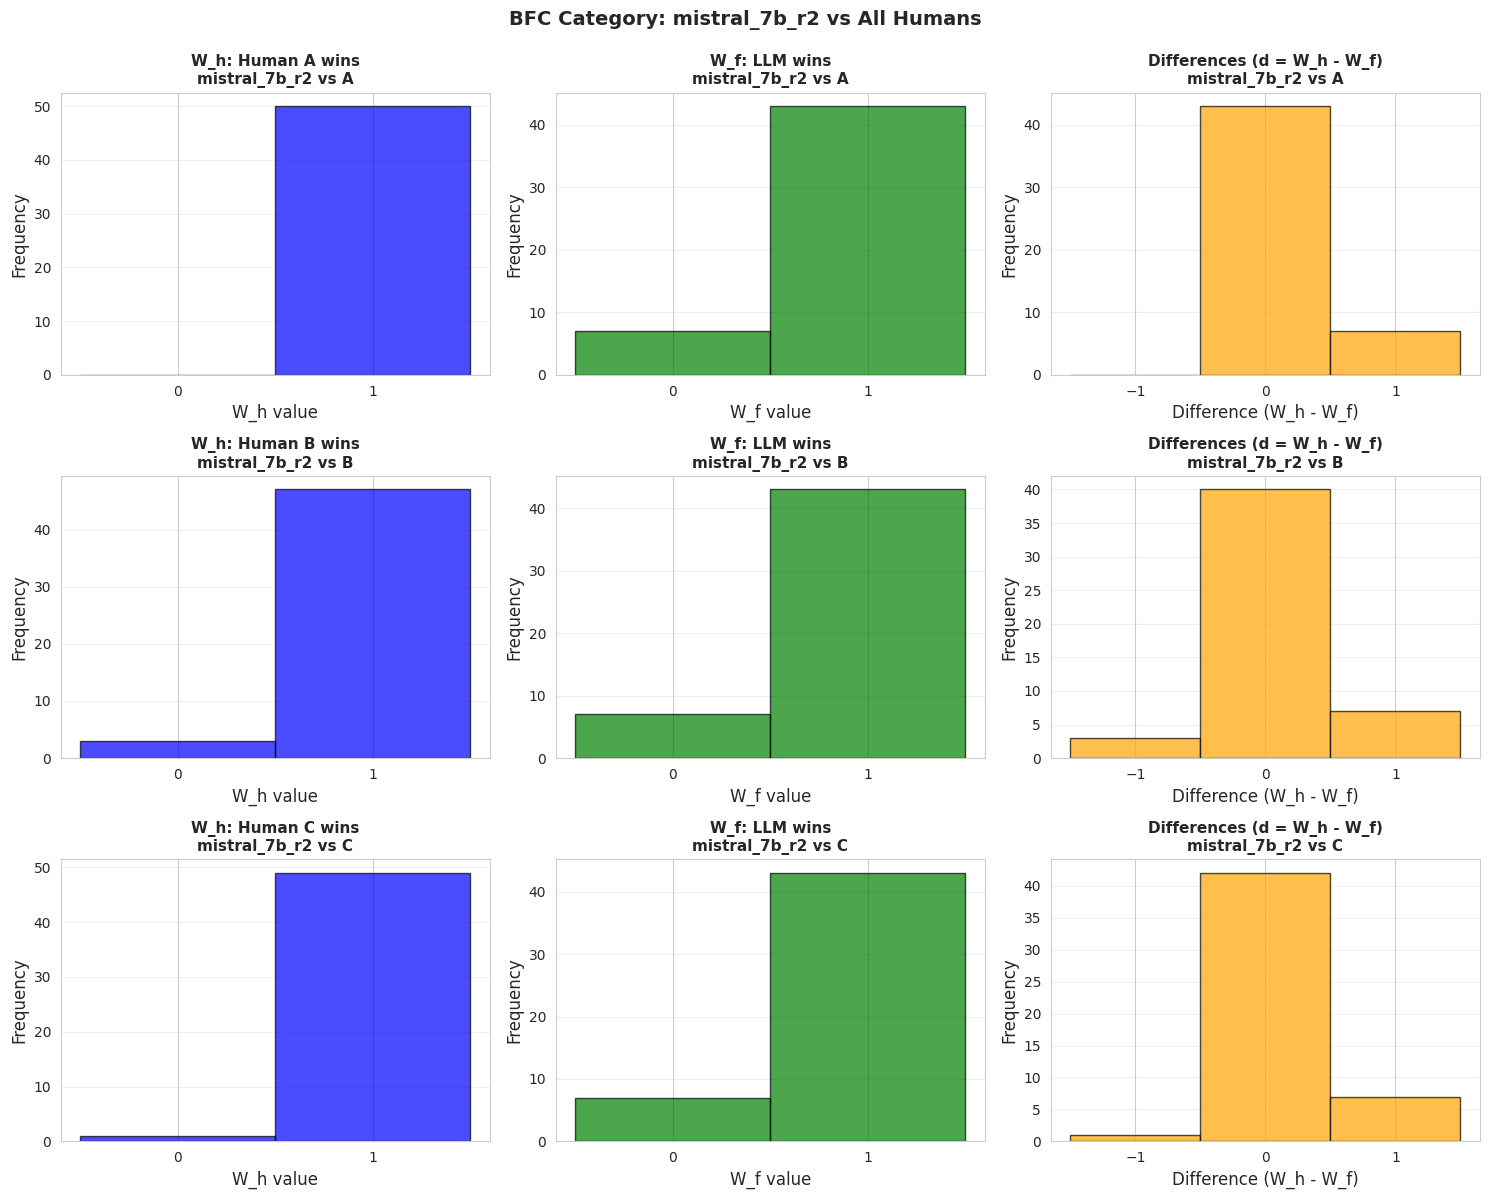


SUMMARY STATISTICS: mistral_7b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  50/50 commits (100.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -43/50 commits (-86.0%)
  Difference distribution:
    d = -1 (LLM better):     0 commits (  0.0%)
    d =  0 (Tie):           43 commits ( 86.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -40/50 commits (-80.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           40 commits ( 80.0%)
    d =  1 (Human better):   7 commits ( 14.0%)

vs Human C:
  W_h (Human wins):  49/50 commits ( 98.0%)
  W_f (LLM wins):    43/50 commits ( 86.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     1 commits (  2.0%)
    d =  0 (

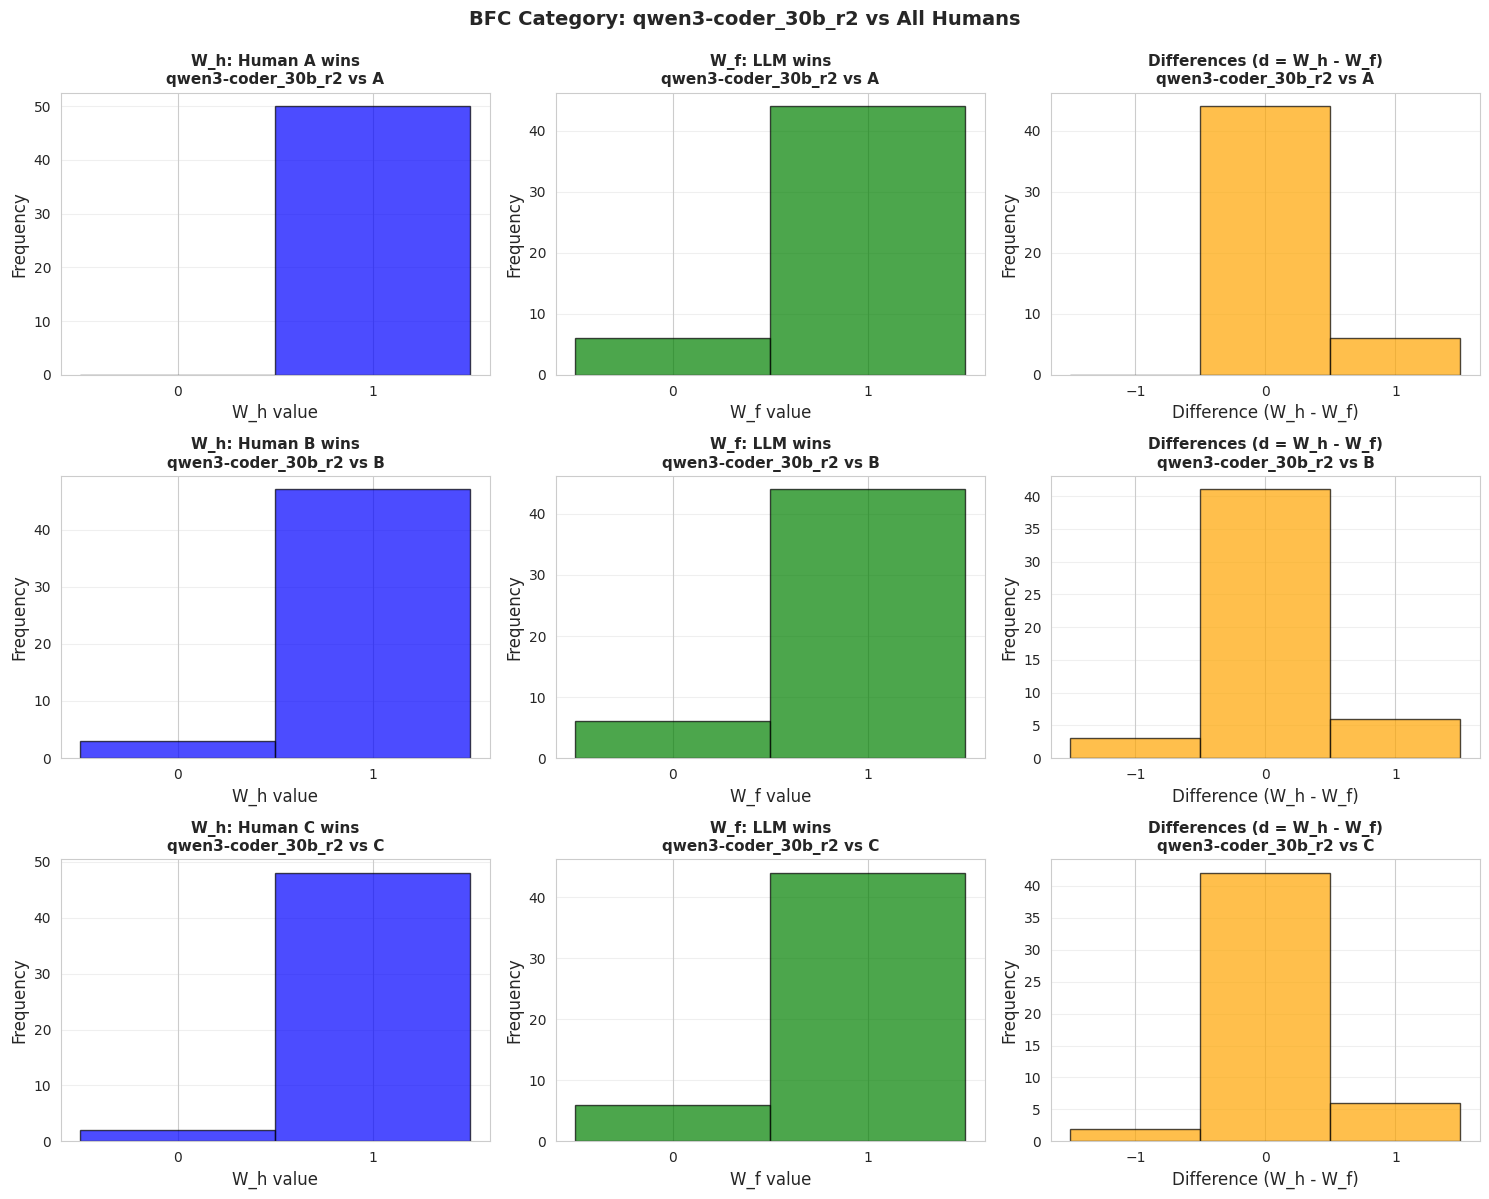


SUMMARY STATISTICS: qwen3-coder_30b_r2 vs All Humans (BFC)
--------------------------------------------------------------------------------

vs Human A:
  W_h (Human wins):  50/50 commits (100.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -44/50 commits (-88.0%)
  Difference distribution:
    d = -1 (LLM better):     0 commits (  0.0%)
    d =  0 (Tie):           44 commits ( 88.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human B:
  W_h (Human wins):  47/50 commits ( 94.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -41/50 commits (-82.0%)
  Difference distribution:
    d = -1 (LLM better):     3 commits (  6.0%)
    d =  0 (Tie):           41 commits ( 82.0%)
    d =  1 (Human better):   6 commits ( 12.0%)

vs Human C:
  W_h (Human wins):  48/50 commits ( 96.0%)
  W_f (LLM wins):    44/50 commits ( 88.0%)
  Ties:             -42/50 commits (-84.0%)
  Difference distribution:
    d = -1 (LLM better):     2 commits (  4.0%)
    d =

In [32]:
llm_names = list(llm_data.keys())

for llm_name in llm_names:
    print(f"\n{'='*100}")
    print(f"LLM: {llm_name}")
    print(f"{'='*100}\n")
    
    # Compute advantage probabilities for this LLM
    adv_probs = compute_advantage_probabilities(
        unified_data['bfc'], llm_name, human_annotators
    )
    
    # Create figure for this LLM
    n_humans = len(human_annotators)
    fig, axes = plt.subplots(n_humans, 3, figsize=(15, 4 * n_humans))
    
    # Handle case where there's only one human (axes won't be 2D)
    if n_humans == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (human, res) in enumerate(adv_probs.items()):
        # Histogram of W_h
        axes[idx, 0].hist(res['W_h'], bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7, color='blue')
        axes[idx, 0].set_xlabel('W_h value', fontsize=12)
        axes[idx, 0].set_ylabel('Frequency', fontsize=12)
        axes[idx, 0].set_title(f'W_h: Human {human} wins\n{llm_name} vs {human}', fontsize=11, fontweight='bold')
        axes[idx, 0].set_xticks([0, 1])
        axes[idx, 0].grid(axis='y', alpha=0.3)
        
        # Histogram of W_f
        axes[idx, 1].hist(res['W_f'], bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7, color='green')
        axes[idx, 1].set_xlabel('W_f value', fontsize=12)
        axes[idx, 1].set_ylabel('Frequency', fontsize=12)
        axes[idx, 1].set_title(f'W_f: LLM wins\n{llm_name} vs {human}', fontsize=11, fontweight='bold')
        axes[idx, 1].set_xticks([0, 1])
        axes[idx, 1].grid(axis='y', alpha=0.3)
        
        # Histogram of differences (d = W_h - W_f)
        d = np.array(res['W_h']) - np.array(res['W_f'])
        axes[idx, 2].hist(d, bins=[-1.5, -0.5, 0.5, 1.5], edgecolor='black', alpha=0.7, color='orange')
        axes[idx, 2].set_xlabel('Difference (W_h - W_f)', fontsize=12)
        axes[idx, 2].set_ylabel('Frequency', fontsize=12)
        axes[idx, 2].set_title(f'Differences (d = W_h - W_f)\n{llm_name} vs {human}', fontsize=11, fontweight='bold')
        axes[idx, 2].set_xticks([-1, 0, 1])
        axes[idx, 2].grid(axis='y', alpha=0.3)
    
    fig.suptitle(f'BFC Category: {llm_name} vs All Humans', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for all humans
    print(f"\nSUMMARY STATISTICS: {llm_name} vs All Humans (BFC)")
    print(f"{'-'*80}\n")
    
    for human, res in adv_probs.items():
        d = np.array(res['W_h']) - np.array(res['W_f'])
        n_ties = len(res['W_h']) - np.sum(res['W_h']) - np.sum(res['W_f'])
        
        print(f"vs Human {human}:")
        print(f"  W_h (Human wins): {np.sum(res['W_h']):3d}/{len(res['W_h'])} commits ({res['rho_h']*100:5.1f}%)")
        print(f"  W_f (LLM wins):   {np.sum(res['W_f']):3d}/{len(res['W_f'])} commits ({res['rho_f']*100:5.1f}%)")
        print(f"  Ties:             {n_ties:3d}/{len(res['W_h'])} commits ({n_ties/len(res['W_h'])*100:5.1f}%)")
        print(f"  Difference distribution:")
        print(f"    d = -1 (LLM better):   {np.sum(d == -1):3d} commits ({np.sum(d == -1)/len(d)*100:5.1f}%)")
        print(f"    d =  0 (Tie):          {np.sum(d == 0):3d} commits ({np.sum(d == 0)/len(d)*100:5.1f}%)")
        print(f"    d =  1 (Human better): {np.sum(d == 1):3d} commits ({np.sum(d == 1)/len(d)*100:5.1f}%)")
        print()